# Introduction

### Define global variables, classifiers and folds.

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report



%matplotlib inline
np.random.seed(0)
random_state = 42

In [131]:
n_PCs = [10, 20, 25, 30, 35, 40, 50, 100, 500]
n_top_features = [30, 35, 40, 50, 75, 100, 150, 175, 200, 250, 500, 1000]
n_neighbors = [1, 2, 3, 5, 8, 10, 20, 50]

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

knn = KNeighborsClassifier(weights='uniform')
logistic = LogisticRegression(class_weight='balanced', C=1e-10, random_state=random_state)
rf = RandomForestClassifier(n_estimators=50,  class_weight='balanced', random_state=random_state)
mlp = MLPClassifier(random_state=random_state, hidden_layer_sizes=(50, 50))
dummy = DummyClassifier(strategy='most_frequent')

### Read dataset. Define noise and mislabeling.

In [132]:
# read data
X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

# merge to have the dataset in one dataframe
data = pd.concat([X, Y], axis=1)

Y['x'].unique()
# assign a numbered label for Y
label_map = {'GBM': 0, 'BC': 1, 'OV': 2, 'LU': 3, 'KI': 4, 'U': 5}
Y['x'] = Y['x'].map(label_map)

/tmp/ipykernel_4911/4019399389.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv('data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
/tmp/ipykernel_4911/4019399389.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Y = pd.read_csv('data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)


In [133]:
def Y_train_mislabeled(Y_train, percentage):
    ''' Return Y_train mislabeled. '''
    num_samples = Y_train.shape[0]
    num_mislabeled_samples = int(num_samples * percentage)
    mislabeled_indices = np.random.choice(num_samples, num_mislabeled_samples, replace=False)
    for idx in mislabeled_indices:
        original_label = Y_train.iloc[idx]
        # ensure that the new label is different from the original one
        replacement_choices = np.setdiff1d([0, 1, 2, 3, 4, 5], [original_label])
        new_label = np.random.choice(replacement_choices)
        Y_train.iloc[idx] = new_label
        
    return Y_train

In [134]:
def splits(gaussian_noise_factor=0, test_size=0.2):
    ''' Split into train and test. Includes noise and mislabeling. '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    noise = np.random.normal(0, 1, Y_train.shape)
    X_train_noisy = X_train + gaussian_noise_factor * noise

    return X_train_noisy, X_test, Y_train, Y_test

### Exploratory data analysis

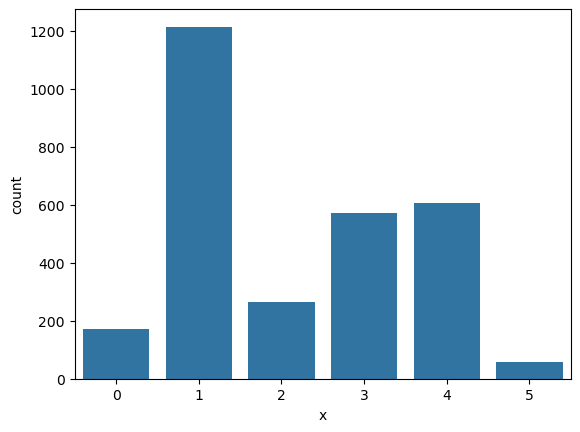

In [135]:
# hist of the class labels
sns.countplot(data=Y, x='x')
plt.show()

Number of components needed to explain 80% variance: 214
Number of components needed to explain 50% variance: 15


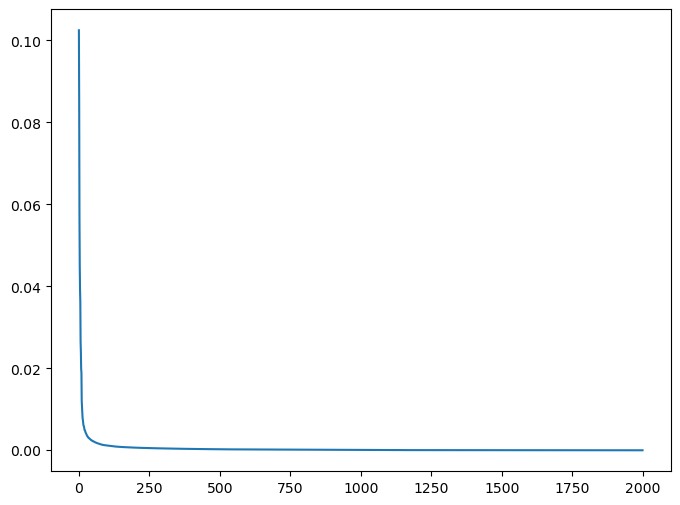

In [136]:
X_train, X_test, Y_train, Y_test = splits(gaussian_noise_factor=0, test_size=0.2)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA()  
principal_components = pca.fit_transform(X_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)

n_components_80 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.8]) + 1
print(f"Number of components needed to explain 80% variance: {n_components_80}")
n_components_50 = len(cumulative_variance_ratios[cumulative_variance_ratios <= 0.5]) + 1
print(f"Number of components needed to explain 50% variance: {n_components_50}")

plt.figure(figsize=(8, 6))
sns.lineplot(data=pca.explained_variance_ratio_)
plt.show()

In [137]:
# Create a VarianceThreshold object with a threshold of 0
vt = VarianceThreshold(threshold=0)

# Fit and transform the data to remove features with 0 variance
X_vt = vt.fit_transform(X)

# Get the number of features after filtering
num_features_after = X_vt.shape[1]

print(f"Number of features after applying VarianceThreshold: {num_features_after}")
print(f"Number of features with variance 0: {X.shape[1]-num_features_after}")

Number of features after applying VarianceThreshold: 1983
Number of features with variance 0: 17


# Setup

### Part 1 - task 1

In [138]:
# setup and function for part 1 - task 1
parameters_1 = {
    'pca__n_components': n_PCs,
    'estimator__n_neighbors': n_neighbors
}

pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('estimator', knn)
])

def grid_search_1(X_train, Y_train):
    grid_search = GridSearchCV(pipeline_1, parameters_1, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, np.ravel(Y_train))
    print('grid_search.best_params_: ', grid_search.best_params_)
    print('grid_search.best_score_: ', grid_search.best_score_)    
    
    return grid_search

def classification_report_1(X_test, Y_test, grid_search_1):
    Y_test_pred_1 = grid_search_1.predict(X_test)
    best_params_1 = grid_search_1.best_params_
    print("Classification Report \nOptimal parameters - ",
        best_params_1['estimator__n_neighbors'], " neighbors and ",
        best_params_1['pca__n_components'], "principal components:\n\n",
        classification_report_1(Y_test, Y_test_pred_1))

In [139]:
def plot_accuracy_vs_nr_neighbors_1(grid_search_1, noise_factor=0, mislabel_percentage=0, test_size=0.2):
    cv_results = grid_search_1.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    components = [params[i]['pca__n_components'] for i in range(len(params))]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(neighbors, mean_test_scores, c=components, alpha=0.8)
    # plt.colorbar(label='Number of PCA Components')
    plt.legend(title="Number of PCA Components")
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Number of Neighbors with PCA Components (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_accuracy_vs_nr_neighbors_1.png")
    plt.show()

def plot_accuracy_vs_nr_pcs_1(grid_search_1, noise_factor, mislabel_percentage, test_size):
    cv_results = grid_search_1.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    components = [params[i]['pca__n_components'] for i in range(len(params))]

    plt.figure(figsize=(10, 6))
    plt.scatter(components, mean_test_scores, c=neighbors, alpha=0.8)
    # plt.colorbar(label='Number of Neighbors')
    plt.legend(title="Number of Neighbors")
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Selection of of PCs (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(n_PCs, [str(tick) for tick in n_PCs])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_accuracy_vs_nr_pcs_1.png")
    plt.show()

### Part 1 - task 2

In [140]:
parameters_2 = {
    'kbest__k': n_top_features,
    'estimator__n_neighbors': n_neighbors,
    'kbest__score_func': [f_classif]
}

pipeline_2 = Pipeline([
    ('th', VarianceThreshold()),
    ('scaler', StandardScaler()),
    ('kbest', SelectKBest(score_func=f_classif)),
    ('estimator', knn)
])

def grid_search_2(X_train, Y_train):
    grid_search = GridSearchCV(pipeline_2, parameters_2, cv=stratified_k_fold, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, np.ravel(Y_train))
    print('grid_search.best_params_: ', grid_search.best_params_)
    print('grid_search.best_score_: ', grid_search.best_score_)
    
    return grid_search

def classification_report_2(X_test, Y_test, grid_search_2):
    Y_test_pred_2 = grid_search_2.predict(X_test)
    best_params_2 = grid_search_2.best_params_
    print("Classification Report \nOptimal parameters - ",
        best_params_2['estimator__n_neighbors'], " neighbors and ",
        best_params_2['kbest__k'], "top features:\n\n",
        classification_report_1(Y_test, Y_test_pred_2))

In [141]:
def plot_accuracy_vs_nr_neighbors_2(grid_search_2, noise_factor=0, mislabel_percentage=0, test_size=0.2):
    cv_results = grid_search_2.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    features = [params[i]['kbest__k'] for i in range(len(params))]
    
    # Create a set of unique number of features for color mapping
    unique_features = list(set(features))
    color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
    
    # Plot initialization
    plt.figure(figsize=(10, 6))
    
    # Scatter plot with color legend
    # for idx, feature in enumerate(unique_features):
    #     # Select data points corresponding to the current number of features
    #     indices = [i for i, f in enumerate(features) if f == feature]
    #     plt.scatter([neighbors[i] for i in indices], [mean_test_scores[i] for i in indices], 
    #                 color=color_map(idx), label=f'Features: {feature}', alpha=0.8)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(neighbors, mean_test_scores, c=features, alpha=0.8)
    # plt.colorbar(label='Number of Features')
    plt.legend(title="Number of Features")
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Number of Neighbors with Features (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_accuracy_vs_nr_neighbors_2.png")
    plt.show()

def plot_accuracy_vs_nr_features_2(grid_search_2, noise_factor=0, mislabel_percentage=0, test_size=0.2):
    cv_results = grid_search_2.cv_results_
    params = cv_results['params']
    mean_test_scores = cv_results['mean_test_score']
    
    neighbors = [params[i]['estimator__n_neighbors'] for i in range(len(params))]
    features = [params[i]['kbest__k'] for i in range(len(params))]

    plt.figure(figsize=(10, 6))
    plt.scatter(features, mean_test_scores, c=neighbors, alpha=0.8)
    # plt.colorbar(label='Number of Neighbors')
    plt.legend(title="Number of Neighbors")
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. Selection of Features (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.xscale('log')
    plt.xticks(n_top_features, [str(tick) for tick in n_top_features])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_accuracy_vs_nr_features_1.png")
    plt.show()

### Part 1 - task 3

In [142]:
### Original training set.

def train_test(X_train, Y_train, X_test, Y_test, model=None, parameters=None):
    ''' Give model's name, train and predict.
        Get train accuracy and test accuracy.
        Get train and test predictions.'''
    pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', dummy)])
    if model is not None:
        pipeline.set_params(classifier=model)
             
    if parameters is not None:
        pipeline.set_params(**parameters)
        
    pipeline.fit(X_train, np.ravel(Y_train))
    Y_test_pred = pipeline.predict(X_test)
    Y_train_pred = pipeline.predict(X_train)
    train_score = balanced_accuracy_score(Y_train, Y_train_pred)
    test_score = balanced_accuracy_score(Y_test, Y_test_pred)

    return pipeline.named_steps['classifier'], train_score, test_score, Y_train_pred, Y_test_pred

def scores_0(X_train, Y_train, X_test, Y_test):

    best_train_score = 0
    scores = []

    for k in n_neighbors:
        _, train_score, test_score, _, _= train_test(X_train, Y_train, X_test, Y_test, model=knn, parameters={'classifier__n_neighbors': k})
        if  train_score > best_train_score:
            best_train_score = train_score
            best_train_k = k
            test_score_for_best_k = test_score
        
        scores.append({'k': k, 'train_score': train_score, 'test_score': test_score})
    
    print('Best training k:', best_train_k)
    print('Best training score:', best_train_score)
    
    return scores, best_train_score, best_train_k, test_score_for_best_k

def optimism_0(scores_0_res, noise_factor, mislabel_percentage, test_size):
    train_scores_1 = [score['train_score'] for score in scores_0_res]
    test_scores_1 = [score['test_score'] for score in scores_0_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, train_scores_1, marker='o', label='train score')
    plt.plot(n_neighbors, test_scores_1, marker='x', label='test score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Original Train Set (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_0.png")
    plt.show()

In [143]:
### PCA

def scores_fixed_pca_1(grid_search_1_res):
    opt_scores_fixed_1 = []

    # best number of components in general
    opt_nr_pca = grid_search_1_res.best_params_['pca__n_components']
    pipeline_1.set_params(pca__n_components=opt_nr_pca)
    for k in n_neighbors:
        pipeline_1.set_params(pca__n_components=opt_nr_pca, estimator__n_neighbors=k)
        pipeline_1.fit(X_train, np.ravel(Y_train))
        Y_test_pred = pipeline_1.predict(X_test)
        
        cv_score = grid_search_1_res.cv_results_['mean_test_score'][idx]
        test_score = balanced_accuracy_score(Y_test, Y_test_pred)

        opt_scores_fixed_1.append({'k': k, 'pca__n_components': opt_nr_pca, 'cv_score': cv_score, 'test_score': test_score})
        print(f"For k={k} and PCA components={opt_nr_pca}, CV Score: {cv_score}, Test Score: {test_score}")
        
    print(opt_scores_fixed_1)
    return opt_scores_fixed_1

def scores_1(grid_search_1_res):
    opt_scores_1 = []

    for k in n_neighbors:
        # best score for current k
        idx = np.argmax([grid_search_1_res.cv_results_['mean_test_score'][i] for i, params in enumerate(grid_search_1_res.cv_results_['params']) if params['estimator__n_neighbors'] == k])
        best_nr_pca_components = grid_search_1_res.cv_results_['params'][idx]['pca__n_components']
        
        # set parameters for the best nr of PC for current k
        pipeline_1.set_params(pca__n_components=best_nr_pca_components, estimator__n_neighbors=k)
        pipeline_1.fit(X_train, np.ravel(Y_train))
        Y_test_pred = pipeline_1.predict(X_test)
        
        cv_score = grid_search_1_res.cv_results_['mean_test_score'][idx]
        test_score = balanced_accuracy_score(Y_test, Y_test_pred)

        opt_scores_1.append({'k': k, 'pca__n_components': best_nr_pca_components, 'cv_score': cv_score, 'test_score': test_score})
        print(f"For k={k} and PCA components={best_nr_pca_components}, CV Score: {cv_score}, Test Score: {test_score}")

    print(opt_scores_1)
    return opt_scores_1

def optimism_vs_nr_pcs_1(scores_1_res, noise_factor, mislabel_percentage, test_size):
    cv_scores_1 = [score['cv_score'] for score in scores_1_res]
    test_scores_1 = [score['test_score'] for score in scores_1_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, cv_scores_1, marker='o', label='cv score')
    plt.plot(n_neighbors, test_scores_1, marker='x', label='test score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Selection of PCs (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_vs_nr_pcs_1.png")
    plt.show()

In [144]:
### Features

def scores_fixed_features_2(grid_search_2_res):
    opt_scores_fixed_2 = []

    # best number of components in general
    opt_nr_features = grid_search_2_res.best_params_['kbest__k']
    pipeline_2.set_params(kbest__k=opt_nr_features)
    for k in n_neighbors:
        pipeline_2.set_params(kbest__k=opt_nr_features, estimator__n_neighbors=k)
        pipeline_2.fit(X_train, np.ravel(Y_train))
        Y_test_pred = pipeline_2.predict(X_test)
        
        cv_score = grid_search_2_res.cv_results_['mean_test_score'][idx]
        test_score = balanced_accuracy_score(Y_test, Y_test_pred)

        opt_scores_fixed_2.append({'k': k, 'nr_features': opt_nr_features, 'cv_score': cv_score, 'test_score': test_score})
        print(f"For k={k} and Features={opt_nr_features}, CV Score: {cv_score}, Test Score: {test_score}")
        
    print(opt_scores_fixed_2)
    return opt_scores_fixed_2

def scores_2(grid_search_2_res):
    opt_scores_2 = []

    for k in n_neighbors:
        # best score for current k
        idx = np.argmax([grid_search_2_res.cv_results_['mean_test_score'][i] for i, params in enumerate(grid_search_2_res.cv_results_['params']) if params['estimator__n_neighbors'] == k])
        best_nr_features = grid_search_2_res.cv_results_['params'][idx]['kbest__k']
        
        # set parameters for the best nr of PC for current k
        pipeline_2.set_params(kbest__k=best_nr_features, estimator__n_neighbors=k)
        pipeline_2.fit(X_train, np.ravel(Y_train))
        Y_test_pred = pipeline_2.predict(X_test)
        
        cv_score = grid_search_2_res.cv_results_['mean_test_score'][idx]
        test_score = balanced_accuracy_score(Y_test, Y_test_pred)

        opt_scores_2.append({'k': k, 'k_best__k': best_nr_features, 'cv_score': cv_score, 'test_score': test_score})
        print(f"For k={k} and number of features={best_nr_features}, CV Score: {cv_score}, Test Score: {test_score}")

    return opt_scores_2

def optimism_vs_nr_features_2(scores_2_res, noise_factor, mislabel_percentage, test_size):
    cv_scores_2 = [score['cv_score'] for score in scores_2_res]
    test_scores_2 = [score['test_score'] for score in scores_2_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, cv_scores_2, marker='o', label='cv score')
    plt.plot(n_neighbors, test_scores_2, marker='x', label='test score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Selection of Features (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_vs_nr_features_1.png")
    plt.show()

In [145]:
### More Plots to Compare Methods (train and another test line)

def optimism_vs_nr_pcs_1_with_0(scores_0_res, scores_1_res, noise_factor, mislabel_percentage, test_size):
    '''Train and Test'''
    train_scores_0 = [score['train_score'] for score in scores_0_res]
    test_scores_0 = [score['test_score'] for score in scores_0_res]
    cv_scores_1 = [score['cv_score'] for score in scores_1_res]
    test_scores_1 = [score['test_score'] for score in scores_1_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, train_scores_0, marker='o', label='train score')
    plt.plot(n_neighbors, cv_scores_1, marker='o', label='cv score')
    plt.plot(n_neighbors, test_scores_1, marker='x', linestyle='--', label='test score (selection of PCs)')
    plt.plot(n_neighbors, test_scores_0, marker='x', linestyle='--', label='test score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Selection of PCs (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_vs_nr_pcs_with_original.png")
    plt.show()

def optimism_vs_nr_features_2_with_0(scores_0_res, scores_2_res, noise_factor, mislabel_percentage, test_size):
    '''Train and Test'''
    train_scores_0 = [score['train_score'] for score in scores_0_res]
    test_scores_0 = [score['test_score'] for score in scores_0_res]
    cv_scores_2 = [score['cv_score'] for score in scores_2_res]
    test_scores_2 = [score['test_score'] for score in scores_2_res]

    plt.figure(figsize=(10, 6))
    plt.plot(n_neighbors, train_scores_0, marker='o', label='train score')
    plt.plot(n_neighbors, cv_scores_2, marker='o', label='cv score')
    plt.plot(n_neighbors, test_scores_2, marker='x', linestyle='--', label='test score (selection of features)')
    plt.plot(n_neighbors, test_scores_0, marker='x', linestyle='--', label='test score')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Score')
    plt.title(f'Optimism of Training: Selection of Features (noise={noise_factor}, mislabel={mislabel_percentage}, test size={test_size})')
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.xticks(n_neighbors, [str(tick) for tick in n_neighbors])
    plt.savefig(f"img/test_{test_size}_mislabel_{mislabel_percentage}_noise_{noise_factor}_optimism_vs_nr_features_with_original.png")
    plt.show()

# Main Functions

In [146]:
def main_sub(X_train, X_test, Y_train, Y_test, noise, mislabel, test_size):
    ''' Input: noise, test size, mislabel percentage.
        Output: tasks 1 to 3. '''
    
    print(f"\n\n ---------- TEST SIZE = {test_size} | MILSABEL PERCENTAGE = {mislabel} ---------- \n\n")
    
    ### Task 1: number of PC that optimize predictive performance
    grid_search_1_res = grid_search_1(X_train, Y_train)
    plot_accuracy_vs_nr_neighbors_1(grid_search_1_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    plot_accuracy_vs_nr_pcs_1(grid_search_1_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)

    ### Task 2: number of features that optimize predictive performance
    grid_search_2_res = grid_search_2(X_train, Y_train)
    plot_accuracy_vs_nr_neighbors_2(grid_search_2_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    plot_accuracy_vs_nr_features_2(grid_search_2_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)

    ## Task 3 - Demonstrate the optimism of training
    scores_0_res, best_train_score, best_train_k, test_score_for_best_k = scores_0(X_train, Y_train, X_test, Y_test)
    opt_scores_1 = scores_1(grid_search_1_res)
    opt_scores_2 = scores_2(grid_search_2_res)

    #opt_scores_fixed_pca_1 = scores_fixed_pca_1(grid_search_1_res)
    #opt_scores_fixed_features_2 = scores_fixed_features_2(grid_search_2_res)

    optimism_0(scores_0_res, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    optimism_vs_nr_pcs_1(opt_scores_1, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    optimism_vs_nr_features_2(opt_scores_2, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    
    optimism_vs_nr_pcs_1_with_0(scores_0_res, opt_scores_1, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)
    optimism_vs_nr_features_2_with_0(scores_0_res, opt_scores_2, noise_factor=noise, mislabel_percentage=mislabel, test_size=test_size)

In [147]:
def main(noise=0):
    ''' Results for different test sizes (task 4) and different mislabeling percentages (part 2).
        Repetition of main_sub (tasks 1 to 3) for different scenarios. '''

    ### Split dataset (task 4)
    for test_size in [0.2, 0.4, 0.7]:
        X_train, X_test, Y_train, Y_test = splits(gaussian_noise_factor=noise, test_size=test_size)
        print(f"\n\n X_train shape = {X_train.shape}, Y_train shape = {Y_train.shape}")
        
        ### Mislabel (part 2)
        for mislabel in [0, 0.2, 0.4, 0.6]:
            Y_train = Y_train_mislabeled(Y_train, percentage=mislabel)
            main_sub(X_train, X_test, Y_train, Y_test, noise=noise, mislabel=mislabel, test_size=test_size)



 X_train shape = (2309, 2000), Y_train shape = (2309, 1)


 ---------- TEST SIZE = 0.2 | MILSABEL PERCENTAGE = 0 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 1, 'pca__n_components': 20}
grid_search.best_score_:  0.9851069645332828


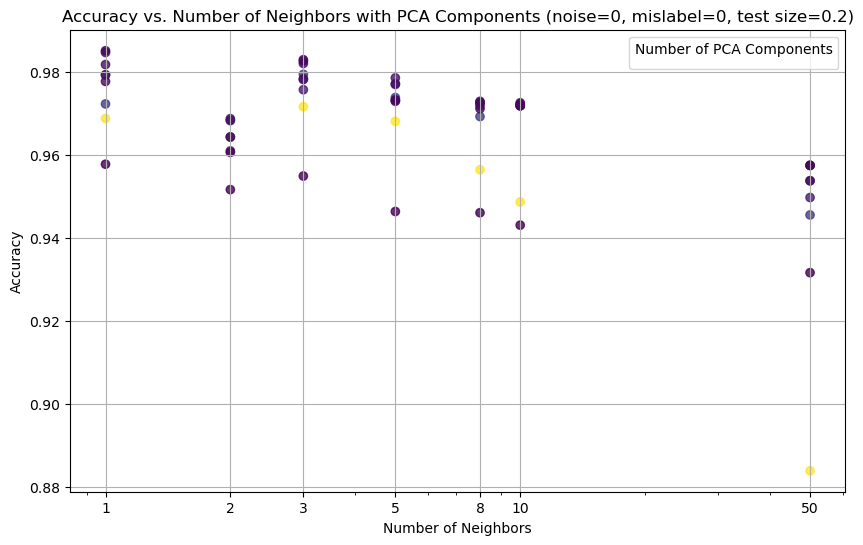

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


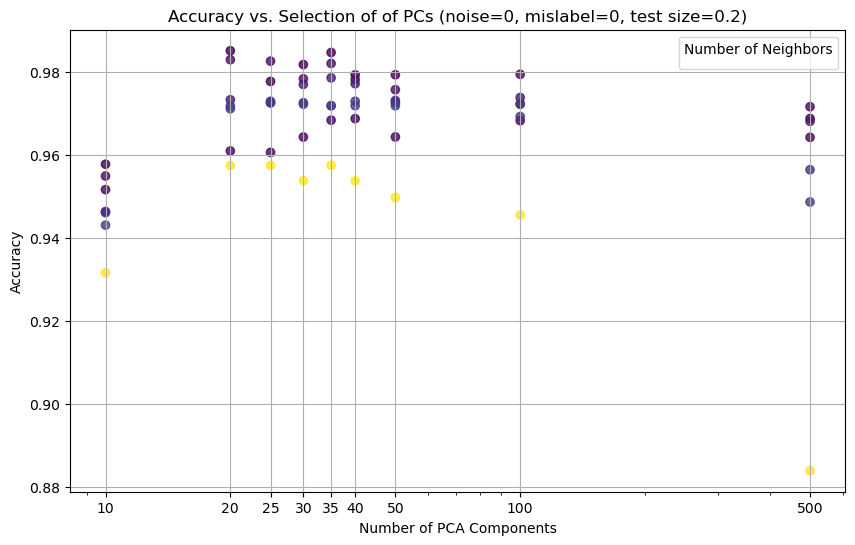

/tmp/ipykernel_4911/266210509.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 3, 'kbest__k': 200, 'kbest__score_func': <function f_classif at 0x7bea42544540>}
grid_search.best_score_:  0.9912738133558914


<Figure size 1000x600 with 0 Axes>

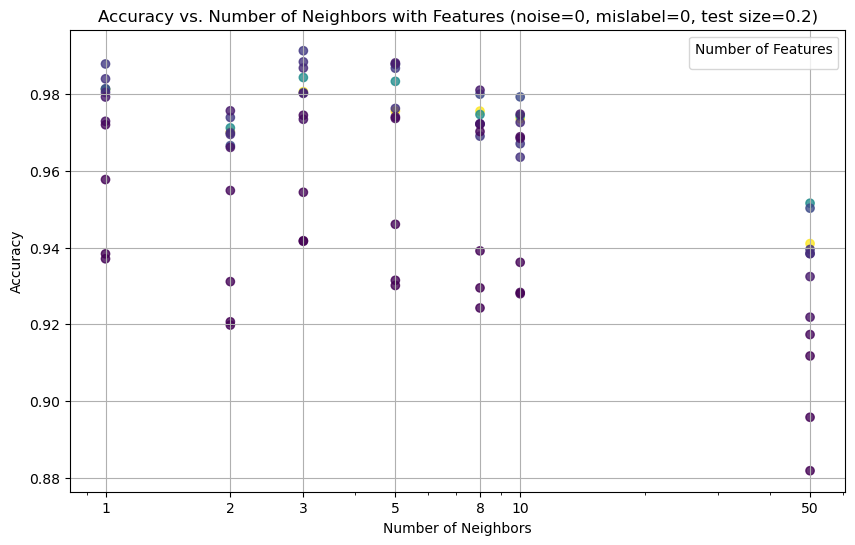

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


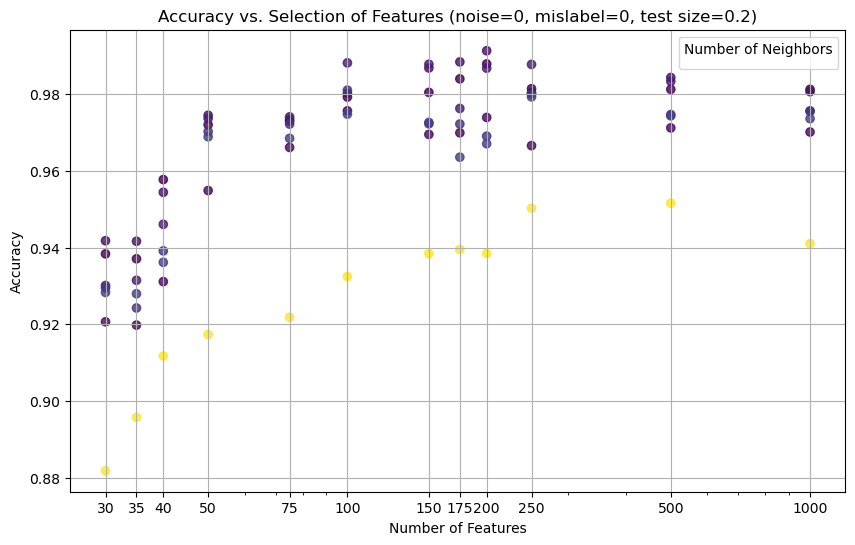

Best training k: 1
Best training score: 1.0
For k=1 and PCA components=20, CV Score: 0.9851069645332828, Test Score: 0.9833676268861455
For k=2 and PCA components=40, CV Score: 0.979281819095856, Test Score: 0.9804379819221216
For k=3 and PCA components=20, CV Score: 0.9851069645332828, Test Score: 0.9951029880588625
For k=5 and PCA components=35, CV Score: 0.9846796141059324, Test Score: 0.9943268708110105
For k=8 and PCA components=40, CV Score: 0.979281819095856, Test Score: 0.9950184102230887
For k=10 and PCA components=25, CV Score: 0.9777035386515962, Test Score: 0.9944114486467844
For k=50 and PCA components=35, CV Score: 0.9846796141059324, Test Score: 0.9533460752005852
[{'k': 1, 'pca__n_components': 20, 'cv_score': 0.9851069645332828, 'test_score': 0.9833676268861455}, {'k': 2, 'pca__n_components': 40, 'cv_score': 0.979281819095856, 'test_score': 0.9804379819221216}, {'k': 3, 'pca__n_components': 20, 'cv_score': 0.9851069645332828, 'test_score': 0.9951029880588625}, {'k': 5, 

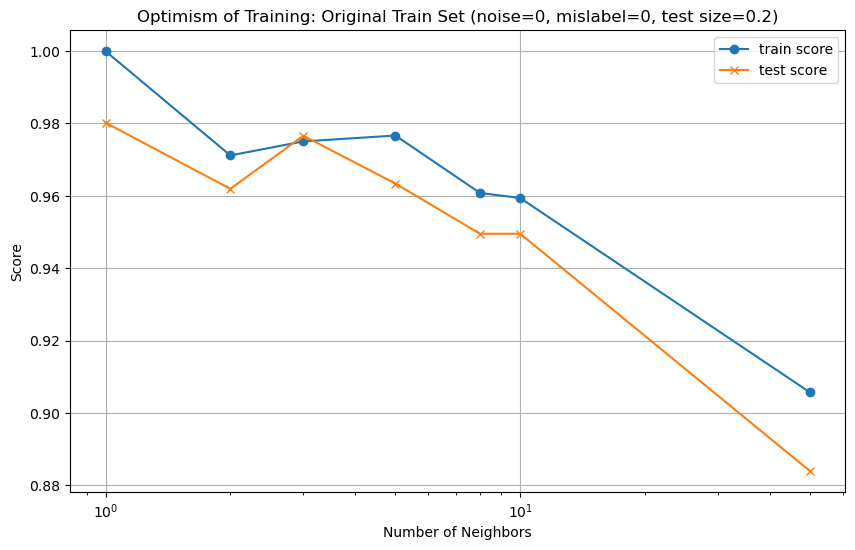

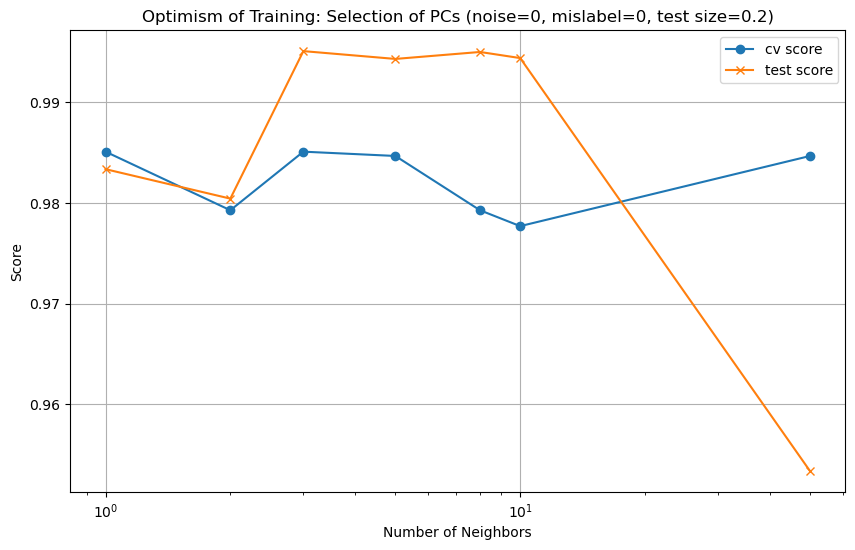

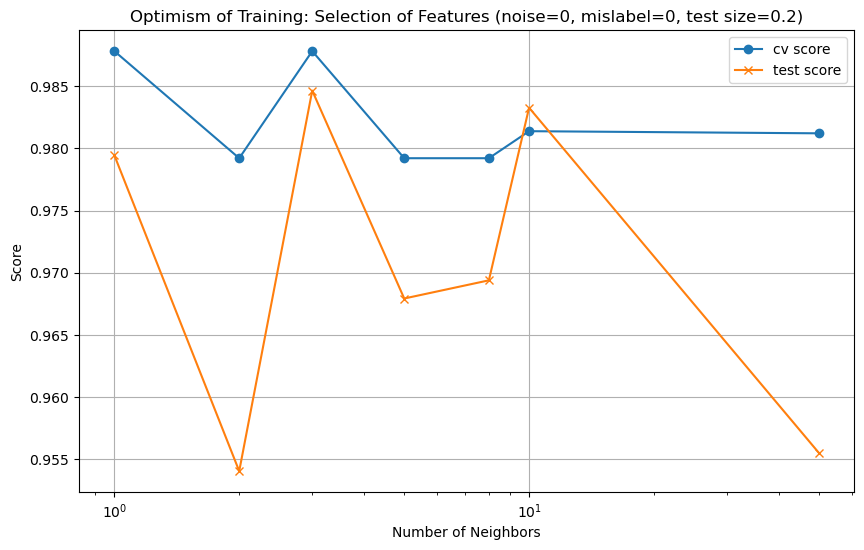

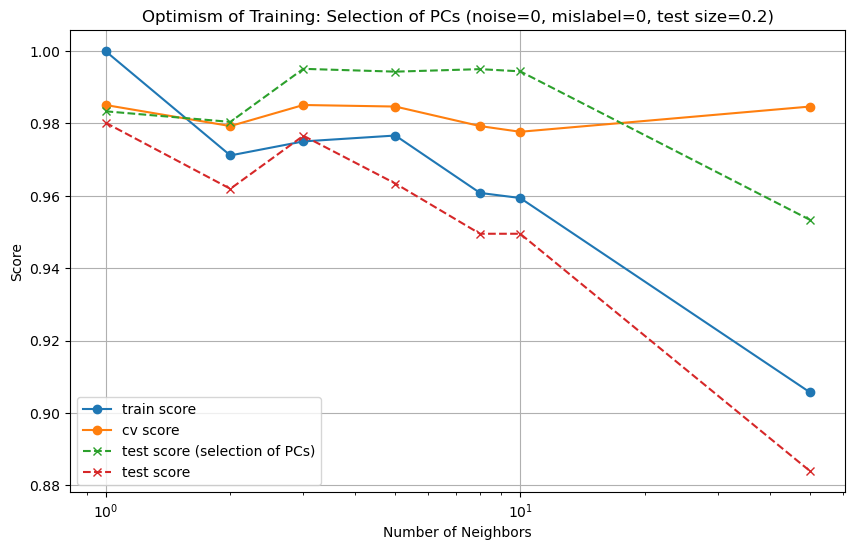

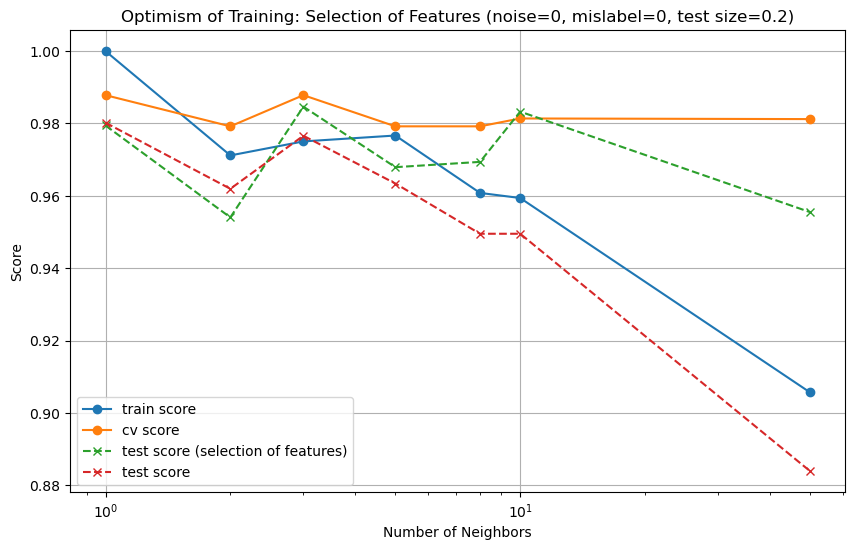



 ---------- TEST SIZE = 0.2 | MILSABEL PERCENTAGE = 0.2 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 10, 'pca__n_components': 30}
grid_search.best_score_:  0.6659567861990464


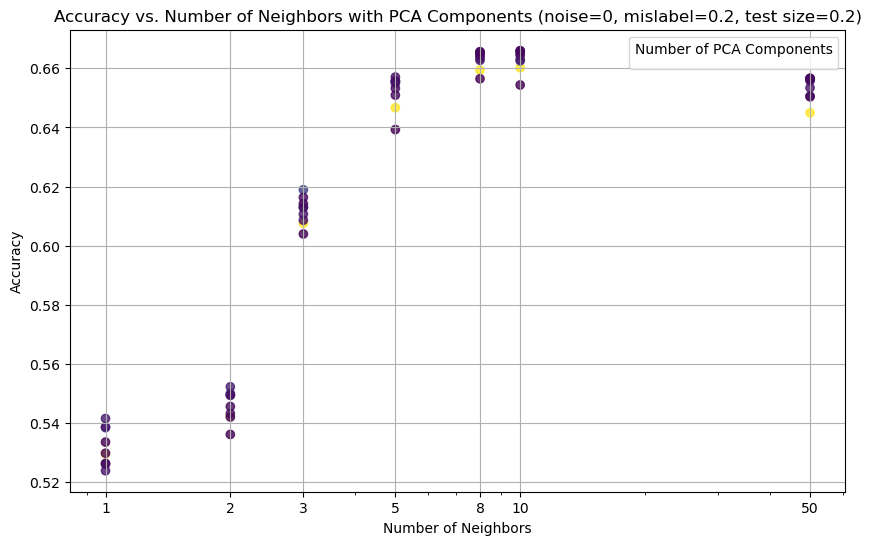

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


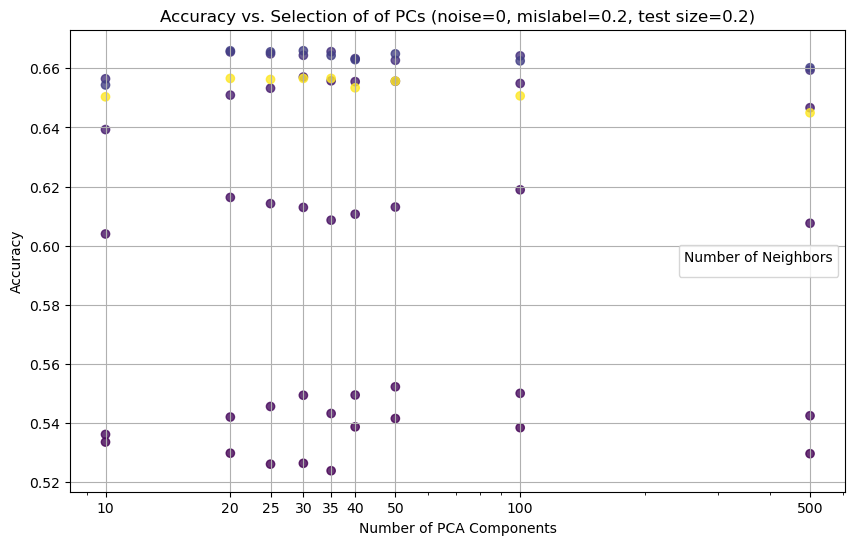

/tmp/ipykernel_4911/266210509.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 10, 'kbest__k': 500, 'kbest__score_func': <function f_classif at 0x7bea42544540>}
grid_search.best_score_:  0.6693702965169752


<Figure size 1000x600 with 0 Axes>

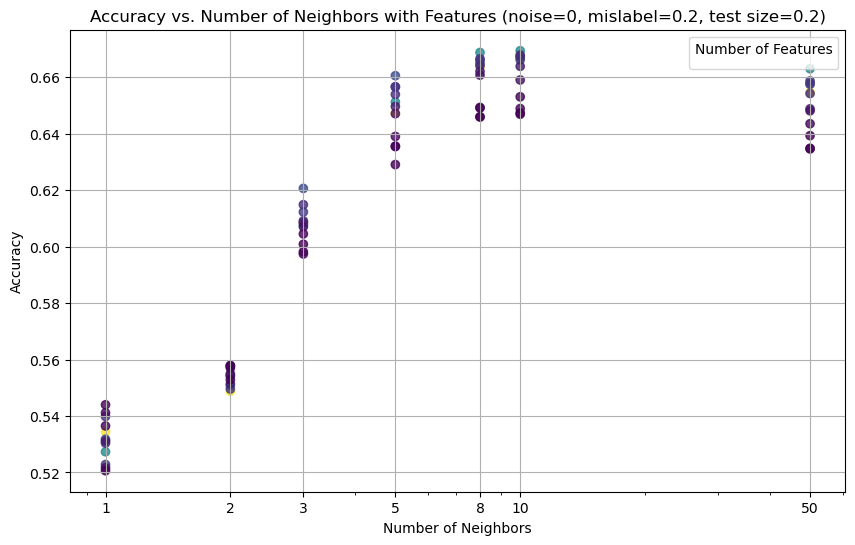

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


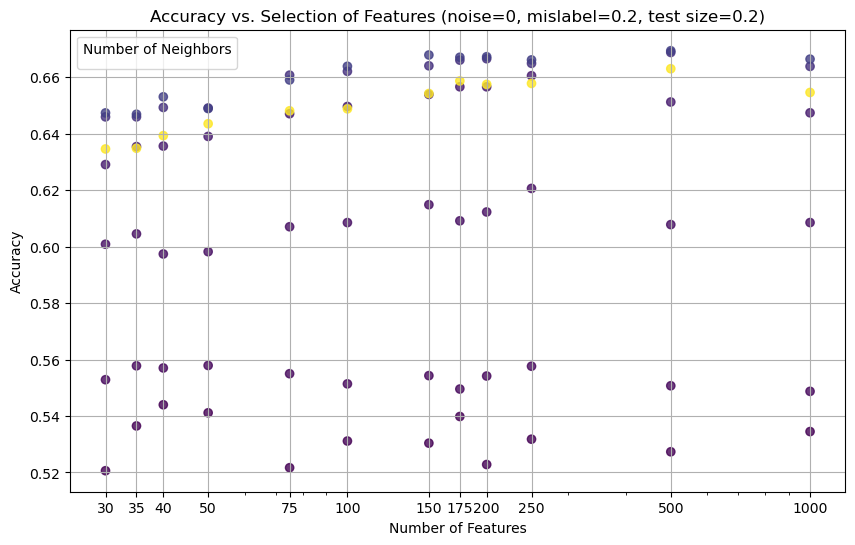

Best training k: 1
Best training score: 1.0
For k=1 and PCA components=50, CV Score: 0.5415632307904599, Test Score: 0.9971662695834236
For k=2 and PCA components=50, CV Score: 0.5415632307904599, Test Score: 0.9804379819221216
For k=3 and PCA components=100, CV Score: 0.538467433785742, Test Score: 0.9950184102230887
For k=5 and PCA components=30, CV Score: 0.5264165867028757, Test Score: 0.9957888591151041
For k=8 and PCA components=35, CV Score: 0.5239054840082502, Test Score: 0.9943268708110105
For k=10 and PCA components=30, CV Score: 0.5264165867028757, Test Score: 0.9944114486467844
For k=50 and PCA components=35, CV Score: 0.5239054840082502, Test Score: 0.9554939345609202
[{'k': 1, 'pca__n_components': 50, 'cv_score': 0.5415632307904599, 'test_score': 0.9971662695834236}, {'k': 2, 'pca__n_components': 50, 'cv_score': 0.5415632307904599, 'test_score': 0.9804379819221216}, {'k': 3, 'pca__n_components': 100, 'cv_score': 0.538467433785742, 'test_score': 0.9950184102230887}, {'k': 

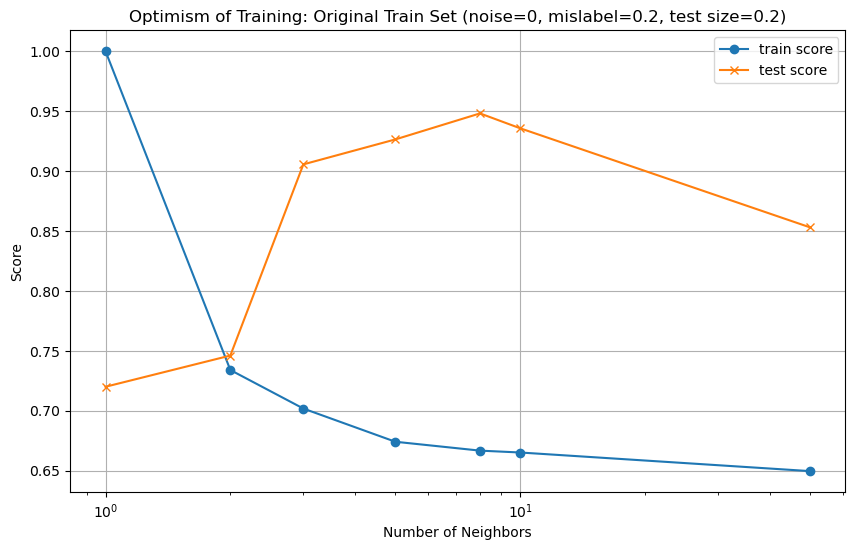

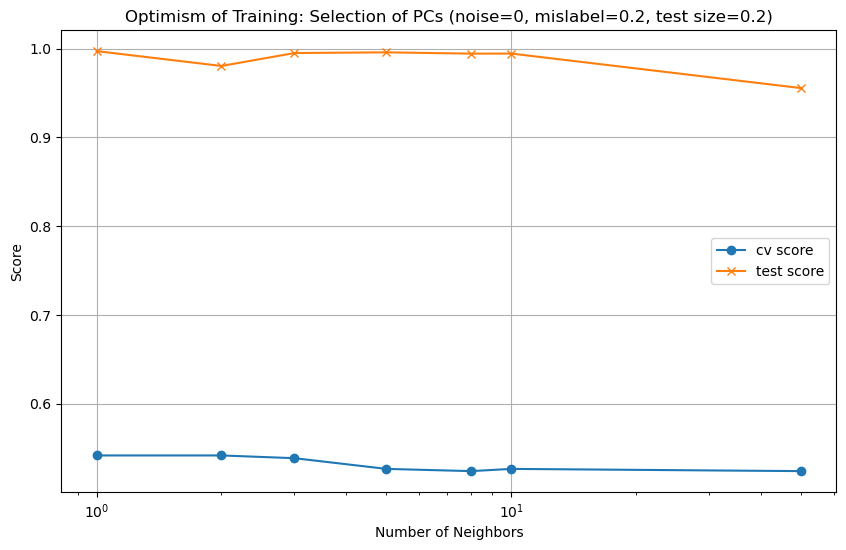

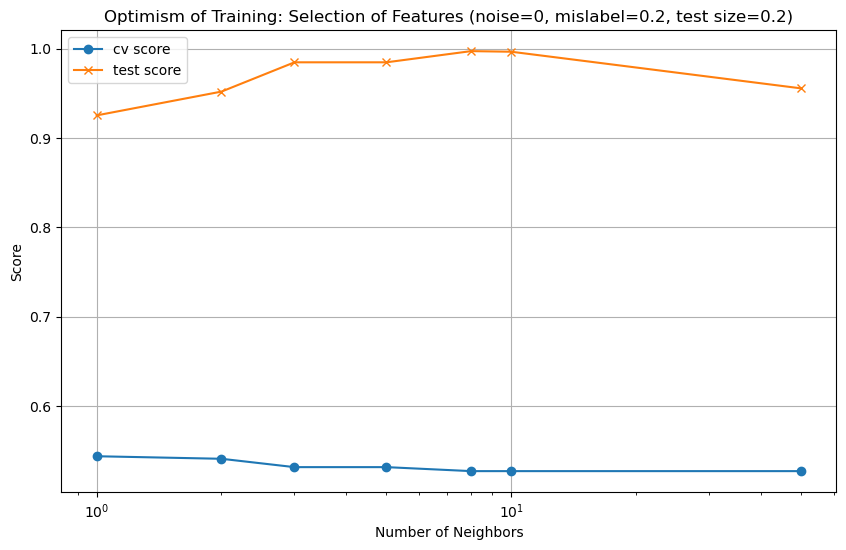

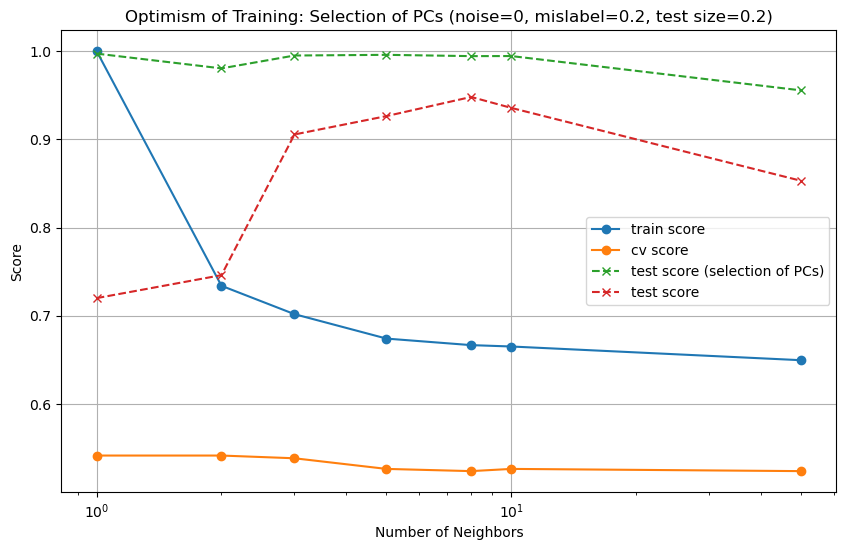

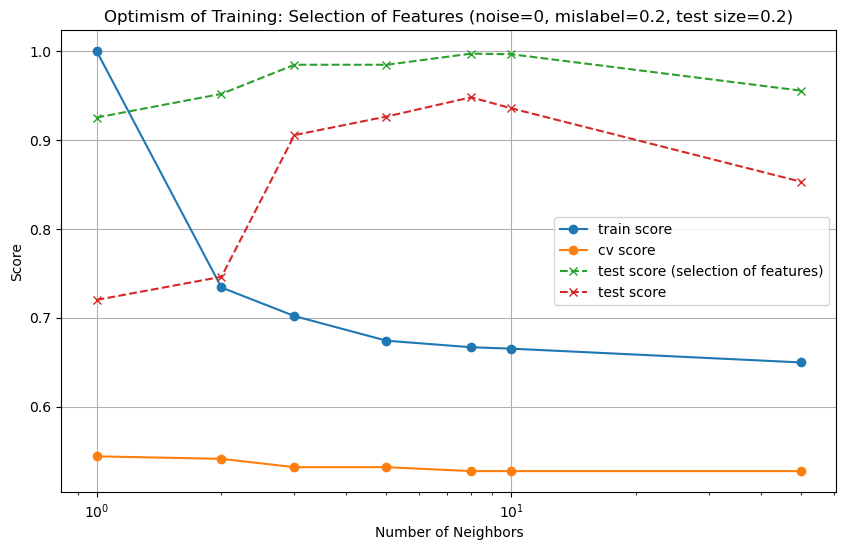



 ---------- TEST SIZE = 0.2 | MILSABEL PERCENTAGE = 0.4 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'pca__n_components': 50}
grid_search.best_score_:  0.4041654152976967


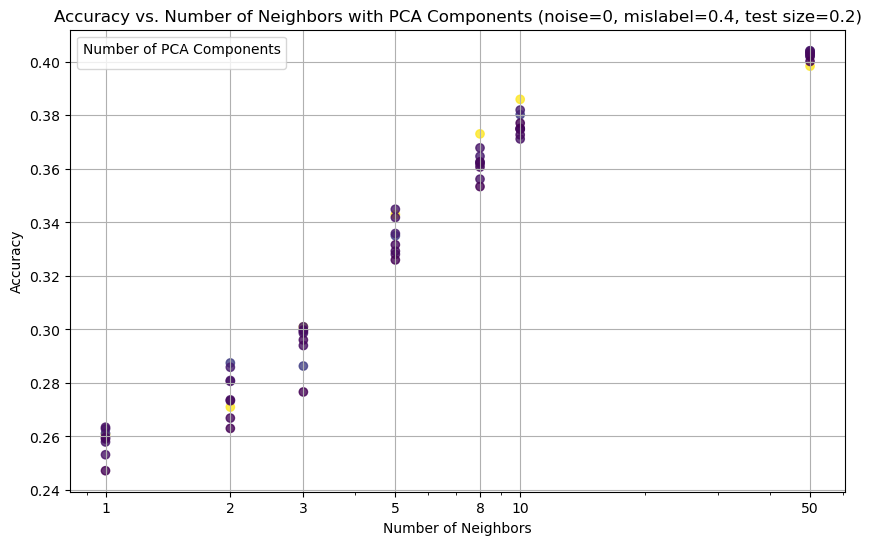

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


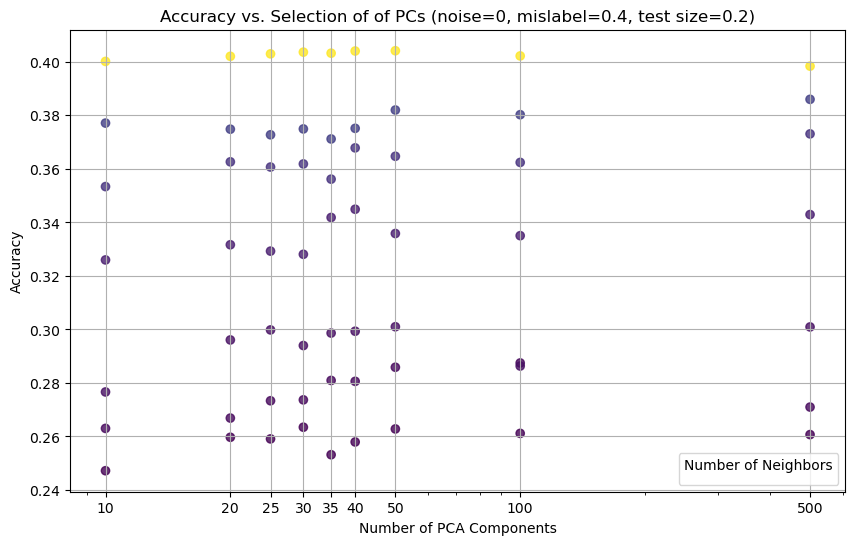

/tmp/ipykernel_4911/266210509.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'kbest__k': 150, 'kbest__score_func': <function f_classif at 0x7bea42544540>}
grid_search.best_score_:  0.4047625421397936


<Figure size 1000x600 with 0 Axes>

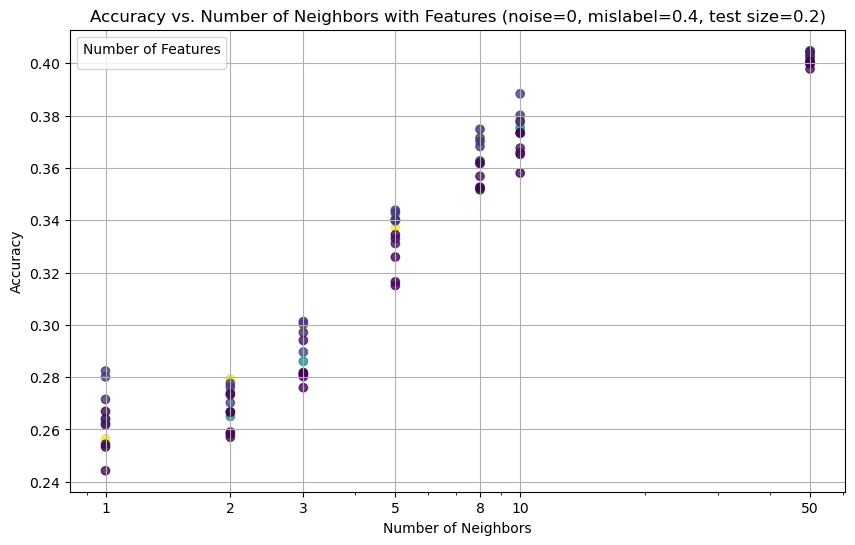

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


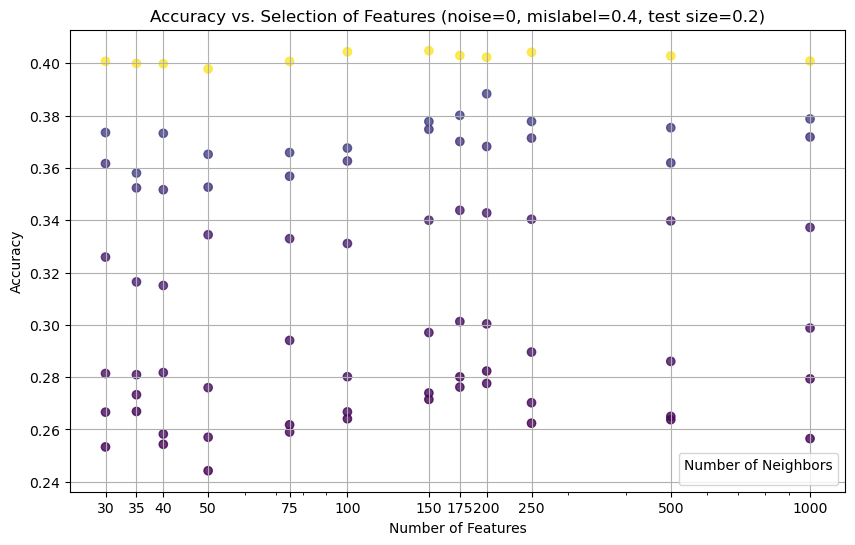

Best training k: 1
Best training score: 1.0
For k=1 and PCA components=30, CV Score: 0.2634661689555179, Test Score: 0.9794468555502429
For k=2 and PCA components=100, CV Score: 0.26116530357602247, Test Score: 0.9971662695834236
For k=3 and PCA components=50, CV Score: 0.2628216047949651, Test Score: 0.9943268708110105
For k=5 and PCA components=40, CV Score: 0.2579541865722976, Test Score: 0.9957888591151041
For k=8 and PCA components=500, CV Score: 0.2607092221549864, Test Score: 0.9634044389451822
For k=10 and PCA components=500, CV Score: 0.2607092221549864, Test Score: 0.9495155500562934
For k=50 and PCA components=50, CV Score: 0.2628216047949651, Test Score: 0.9540319462568266
[{'k': 1, 'pca__n_components': 30, 'cv_score': 0.2634661689555179, 'test_score': 0.9794468555502429}, {'k': 2, 'pca__n_components': 100, 'cv_score': 0.26116530357602247, 'test_score': 0.9971662695834236}, {'k': 3, 'pca__n_components': 50, 'cv_score': 0.2628216047949651, 'test_score': 0.9943268708110105}, 

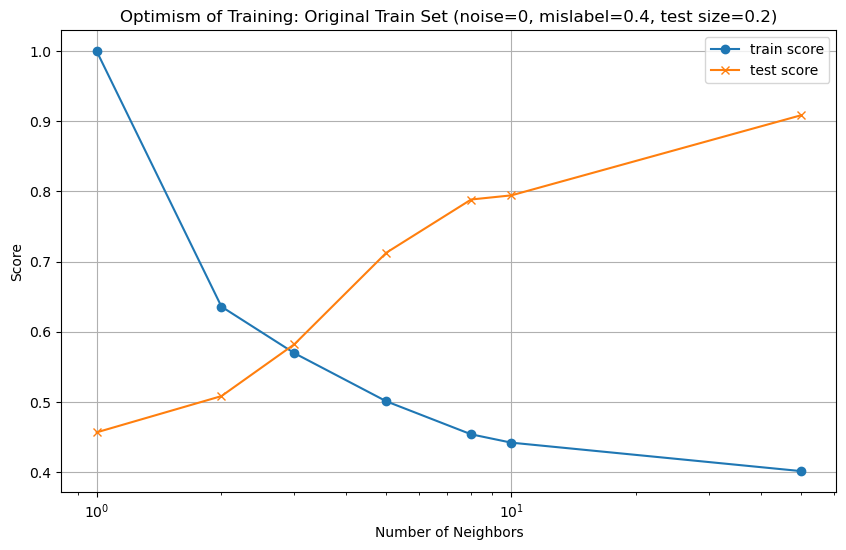

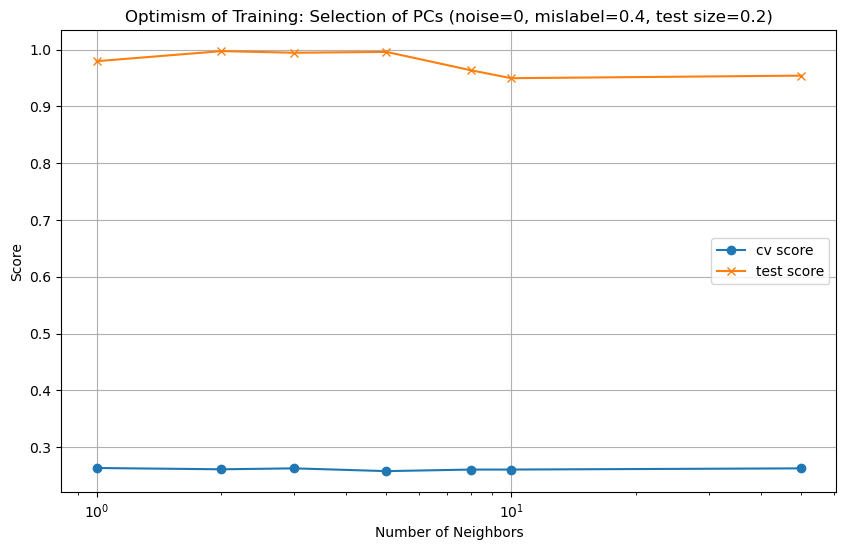

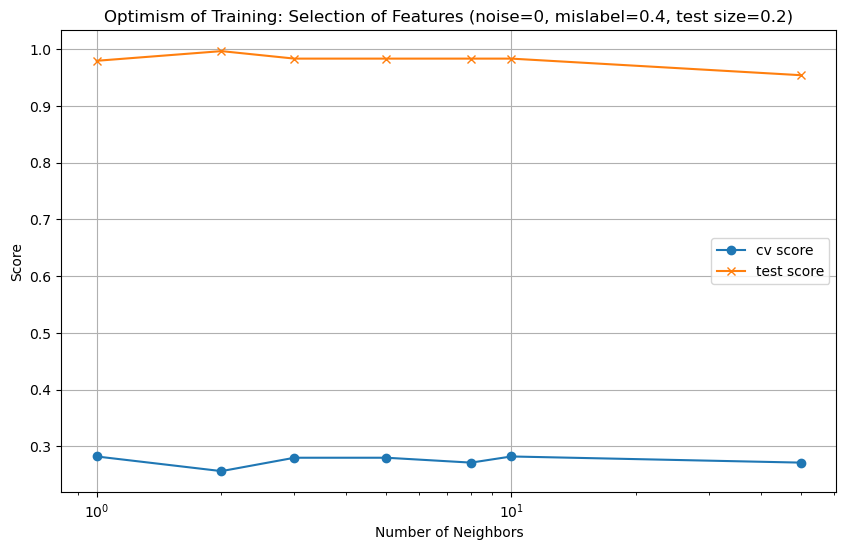

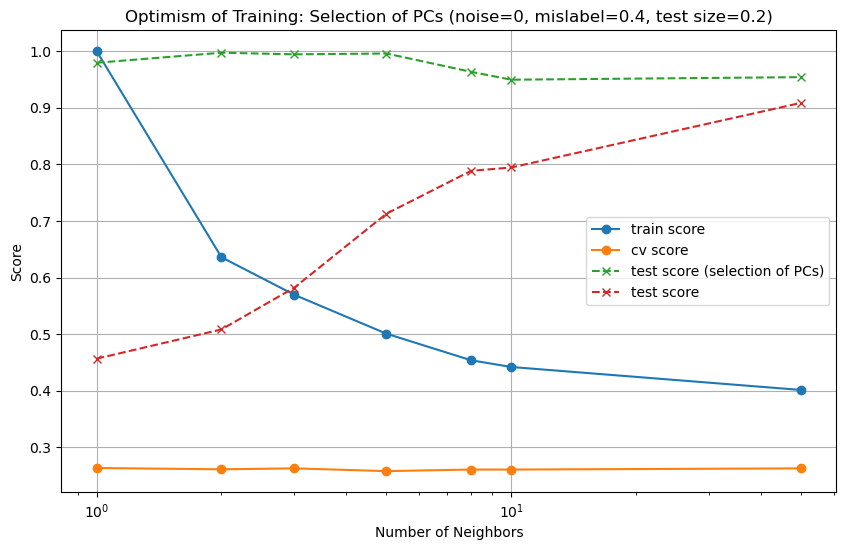

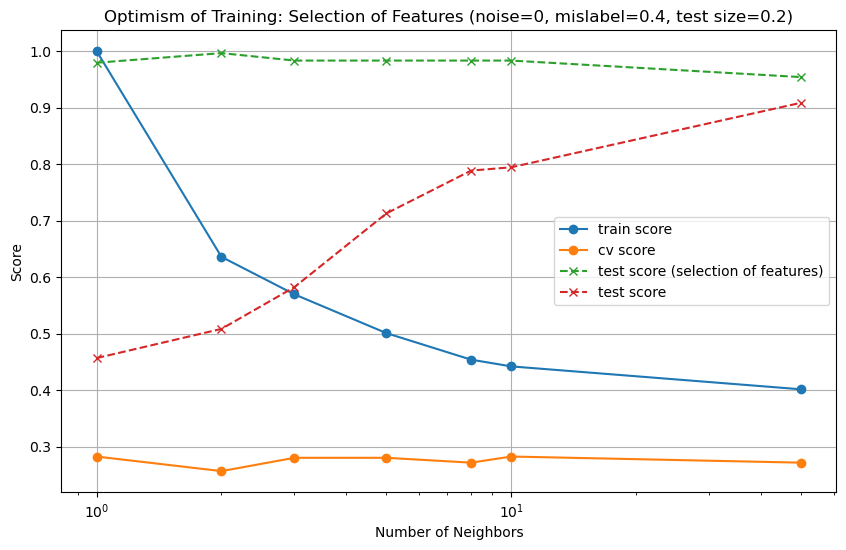



 ---------- TEST SIZE = 0.2 | MILSABEL PERCENTAGE = 0.6 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'pca__n_components': 500}
grid_search.best_score_:  0.22021179894692477


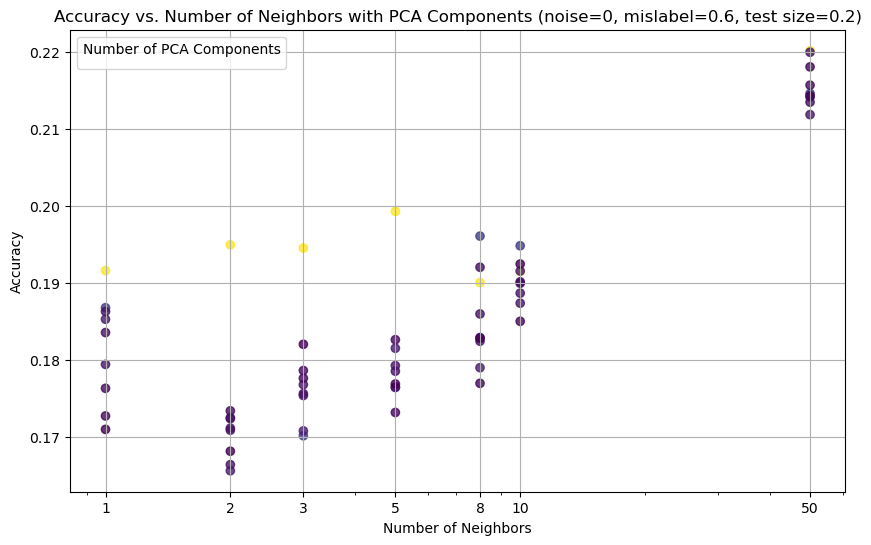

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


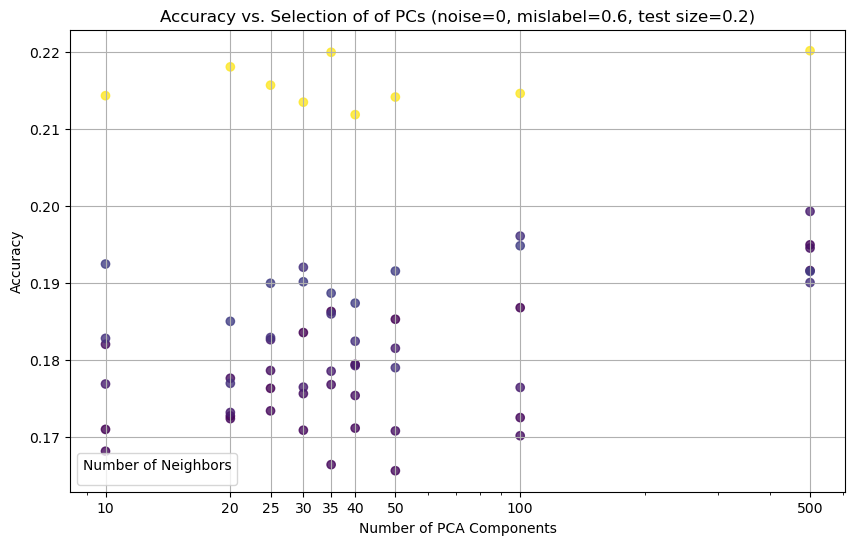

/tmp/ipykernel_4911/266210509.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'kbest__k': 1000, 'kbest__score_func': <function f_classif at 0x7bea42544540>}
grid_search.best_score_:  0.2268154381354052


<Figure size 1000x600 with 0 Axes>

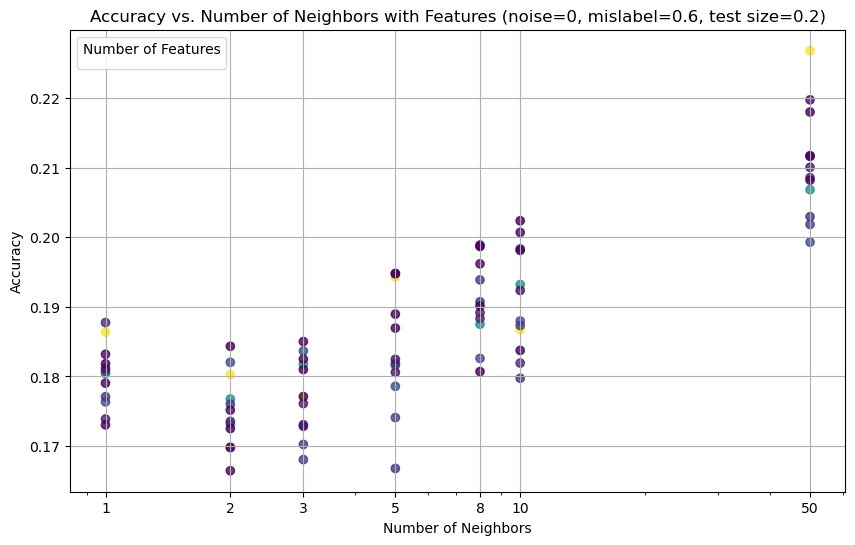

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


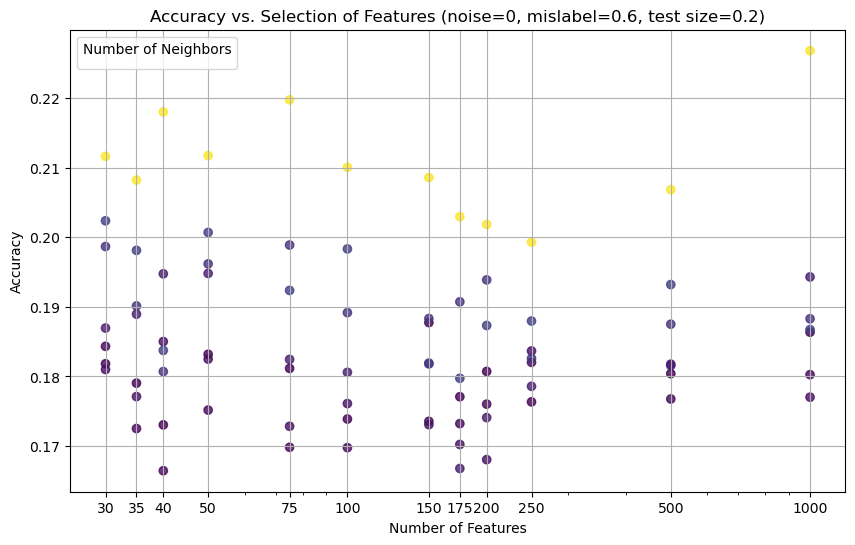

Best training k: 1
Best training score: 1.0
For k=1 and PCA components=500, CV Score: 0.19165636282986115, Test Score: 0.9787553161381649
For k=2 and PCA components=500, CV Score: 0.19165636282986115, Test Score: 0.9634044389451822
For k=3 and PCA components=500, CV Score: 0.19165636282986115, Test Score: 0.9780694450819234
For k=5 and PCA components=500, CV Score: 0.19165636282986115, Test Score: 0.9627185678889408
For k=8 and PCA components=100, CV Score: 0.18683624994133233, Test Score: 0.9936409997547689
For k=10 and PCA components=100, CV Score: 0.18683624994133233, Test Score: 0.9943268708110105
For k=50 and PCA components=500, CV Score: 0.19165636282986115, Test Score: 0.8839016307561408
[{'k': 1, 'pca__n_components': 500, 'cv_score': 0.19165636282986115, 'test_score': 0.9787553161381649}, {'k': 2, 'pca__n_components': 500, 'cv_score': 0.19165636282986115, 'test_score': 0.9634044389451822}, {'k': 3, 'pca__n_components': 500, 'cv_score': 0.19165636282986115, 'test_score': 0.97806

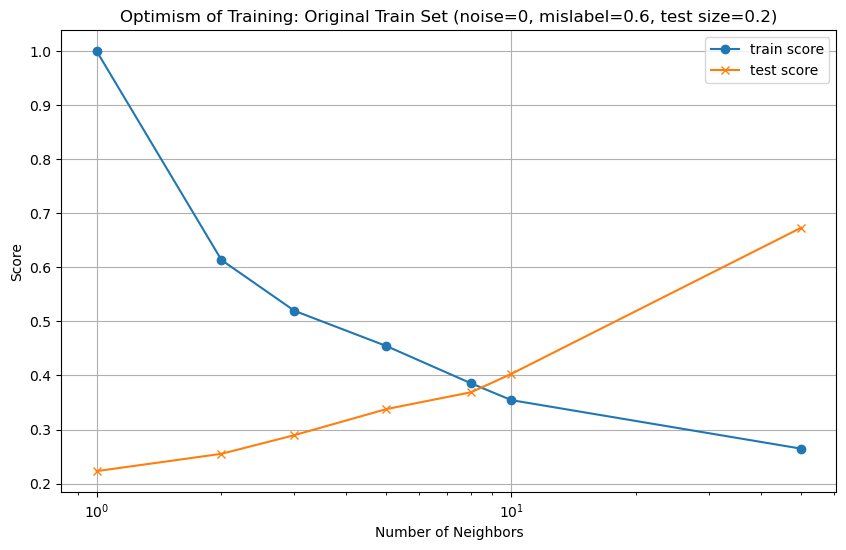

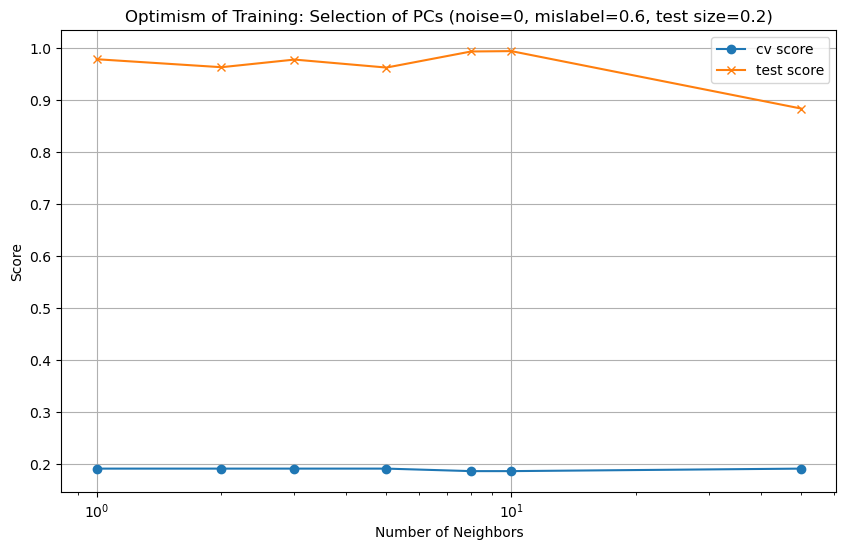

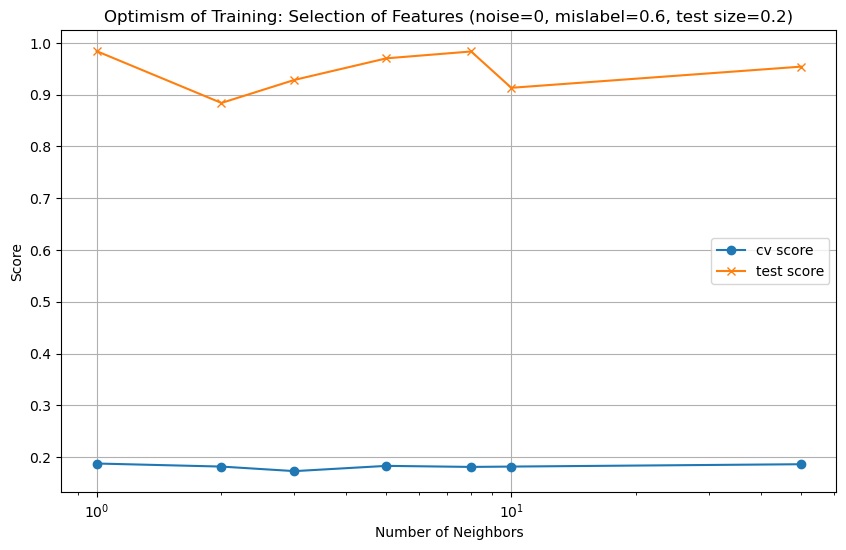

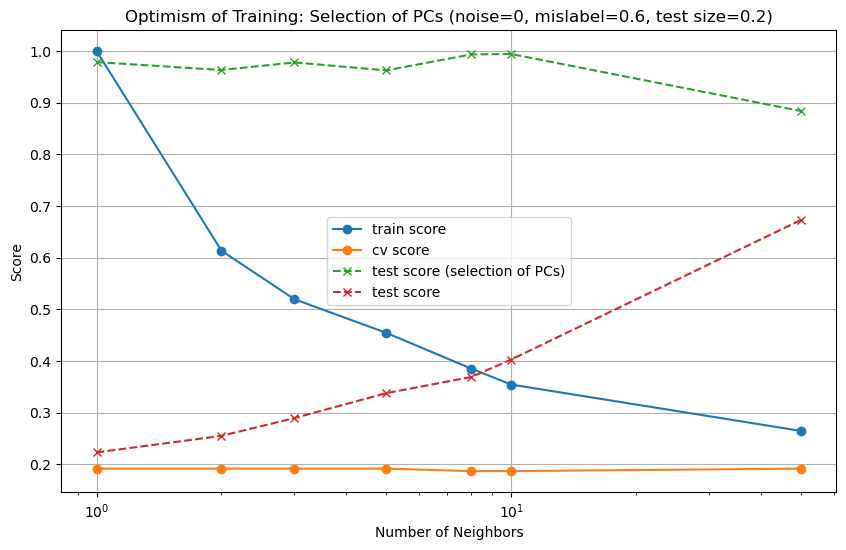

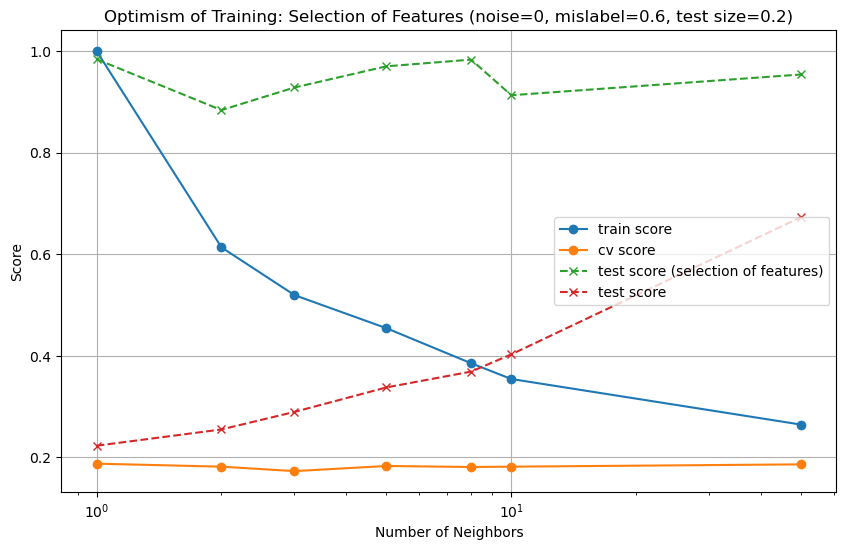



 X_train shape = (1732, 2000), Y_train shape = (1732, 1)


 ---------- TEST SIZE = 0.4 | MILSABEL PERCENTAGE = 0 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 1, 'pca__n_components': 20}
grid_search.best_score_:  0.9752173082355832


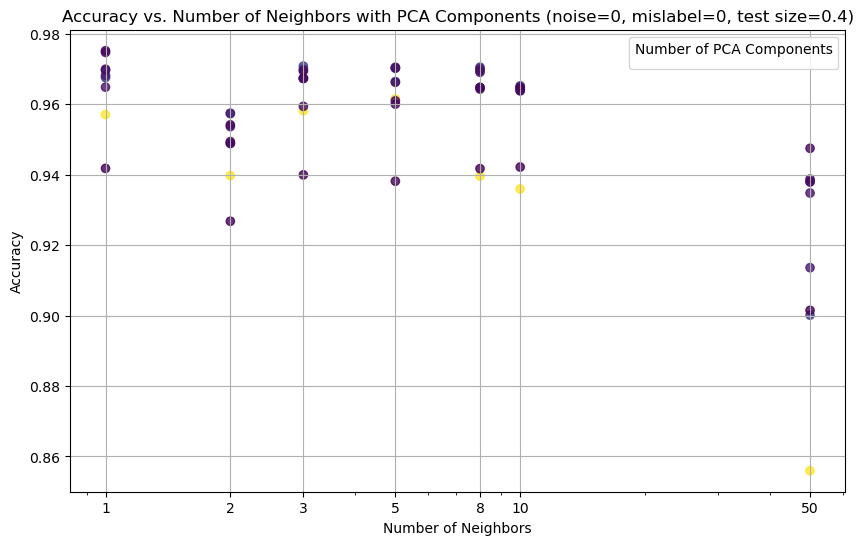

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


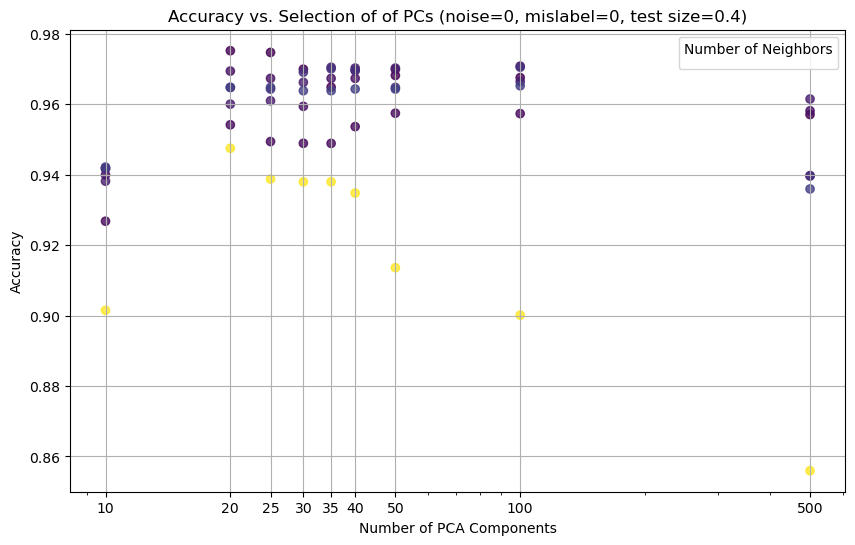

/tmp/ipykernel_4911/266210509.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 1, 'kbest__k': 200, 'kbest__score_func': <function f_classif at 0x7bea42544540>}
grid_search.best_score_:  0.985661464059517


<Figure size 1000x600 with 0 Axes>

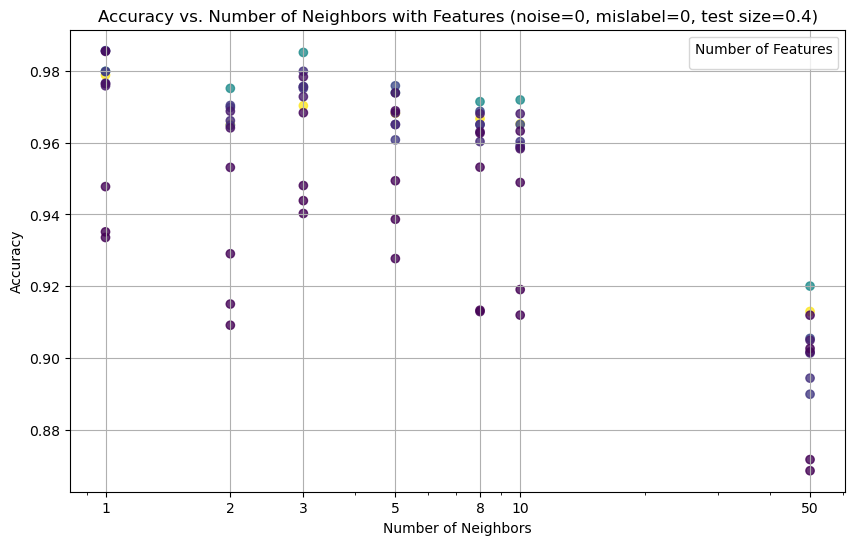

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


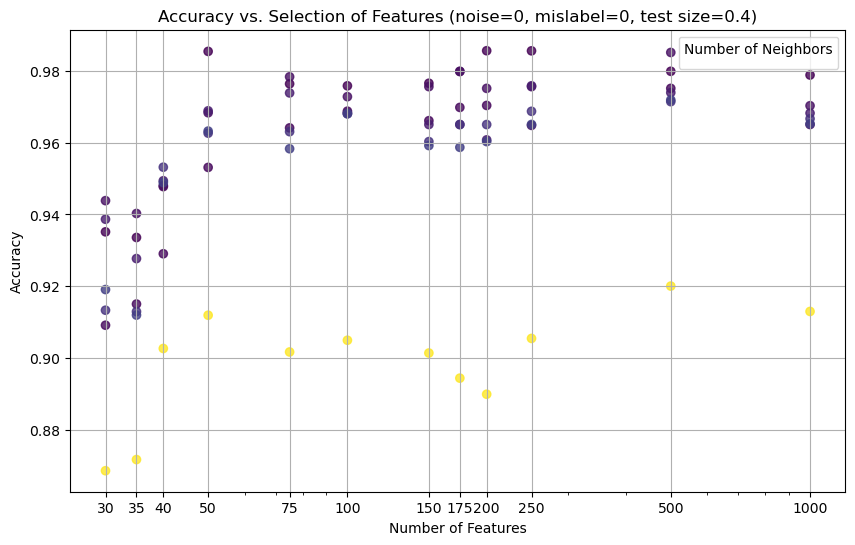

Best training k: 1
Best training score: 1.0
For k=1 and PCA components=20, CV Score: 0.9752173082355832, Test Score: 0.9833676268861455
For k=2 and PCA components=50, CV Score: 0.9681990310683204, Test Score: 0.9804379819221216
For k=3 and PCA components=100, CV Score: 0.9675850173468898, Test Score: 0.9950184102230887
For k=5 and PCA components=35, CV Score: 0.9648733771352497, Test Score: 0.9936409997547689
For k=8 and PCA components=100, CV Score: 0.9675850173468898, Test Score: 0.9943268708110105
For k=10 and PCA components=100, CV Score: 0.9675850173468898, Test Score: 0.9943268708110105
For k=50 and PCA components=20, CV Score: 0.9752173082355832, Test Score: 0.9533460752005852
[{'k': 1, 'pca__n_components': 20, 'cv_score': 0.9752173082355832, 'test_score': 0.9833676268861455}, {'k': 2, 'pca__n_components': 50, 'cv_score': 0.9681990310683204, 'test_score': 0.9804379819221216}, {'k': 3, 'pca__n_components': 100, 'cv_score': 0.9675850173468898, 'test_score': 0.9950184102230887}, {'

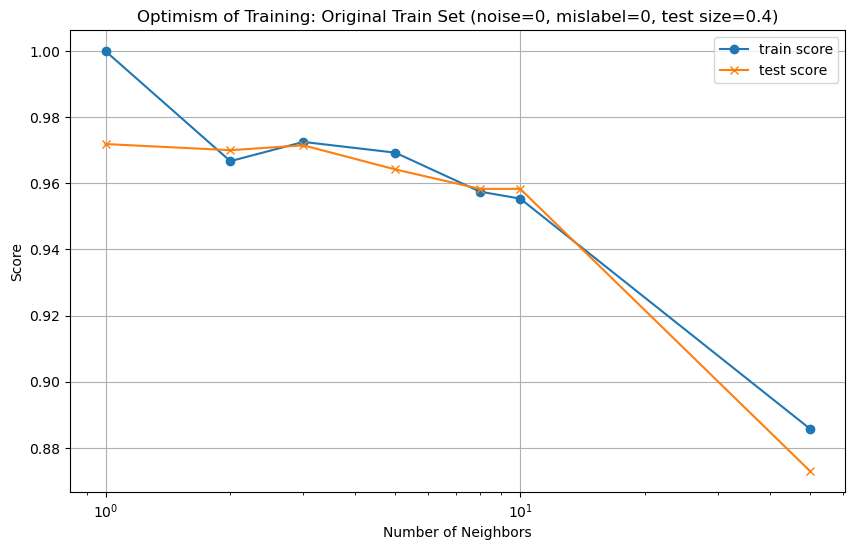

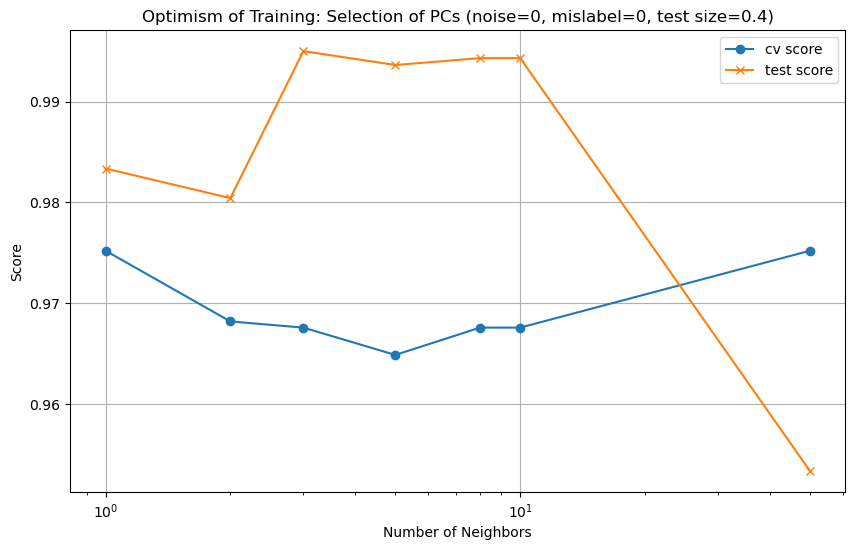

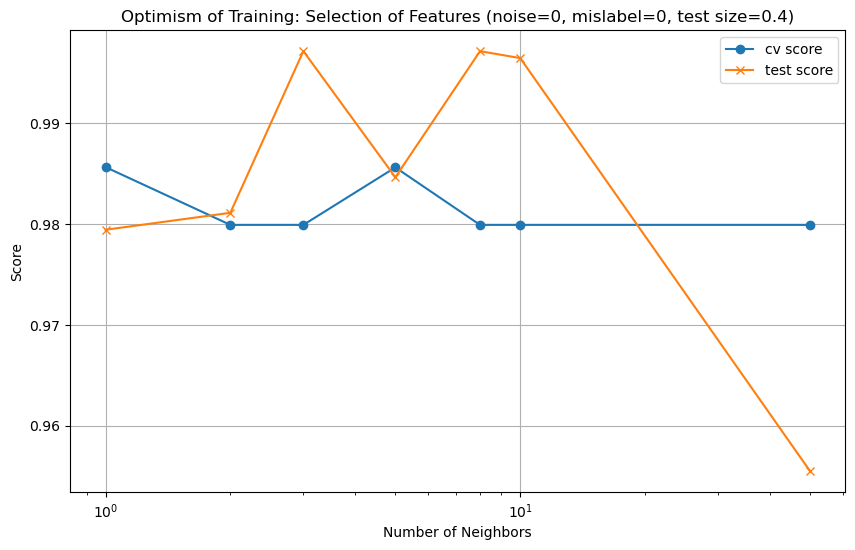

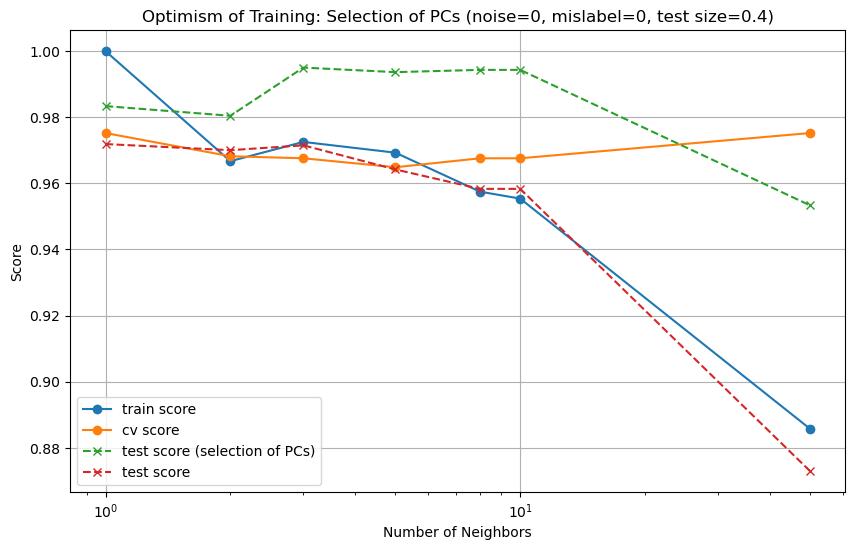

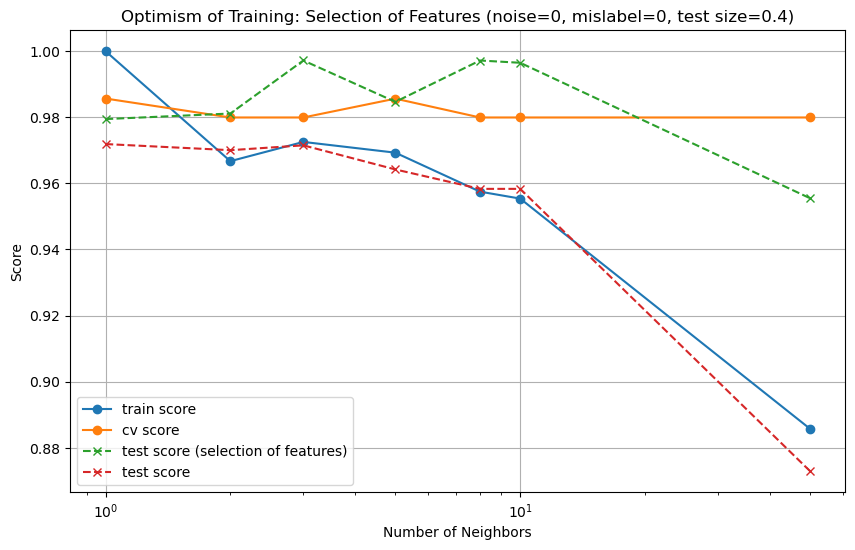



 ---------- TEST SIZE = 0.4 | MILSABEL PERCENTAGE = 0.2 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 8, 'pca__n_components': 30}
grid_search.best_score_:  0.6823949857817144


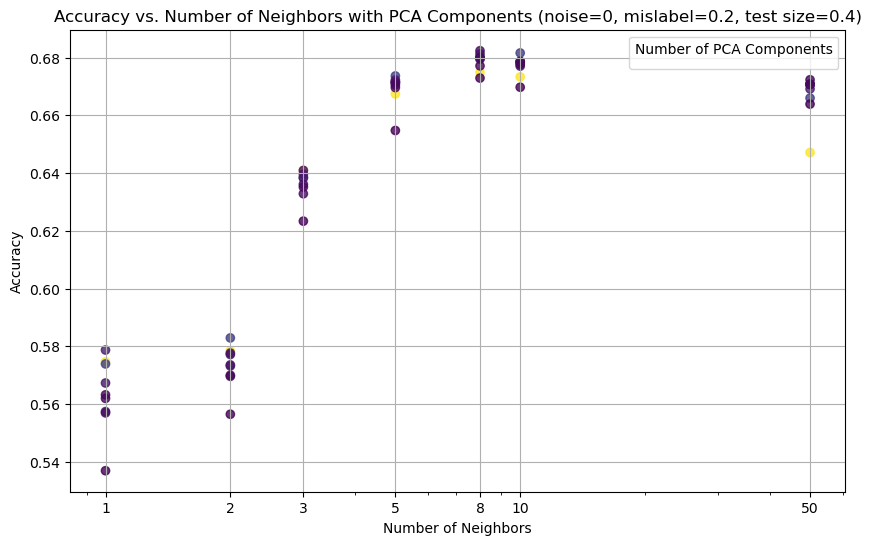

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


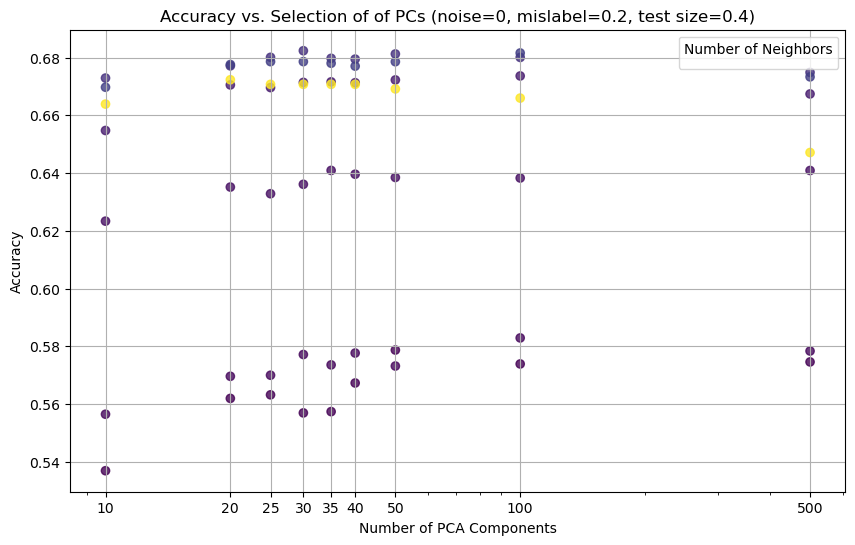

/tmp/ipykernel_4911/266210509.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 10, 'kbest__k': 175, 'kbest__score_func': <function f_classif at 0x7bea42544540>}
grid_search.best_score_:  0.6889779662777384


<Figure size 1000x600 with 0 Axes>

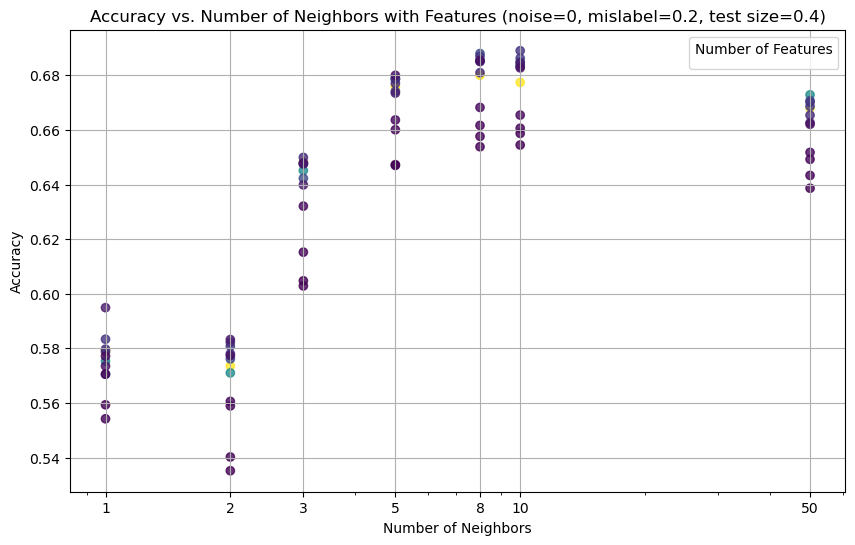

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


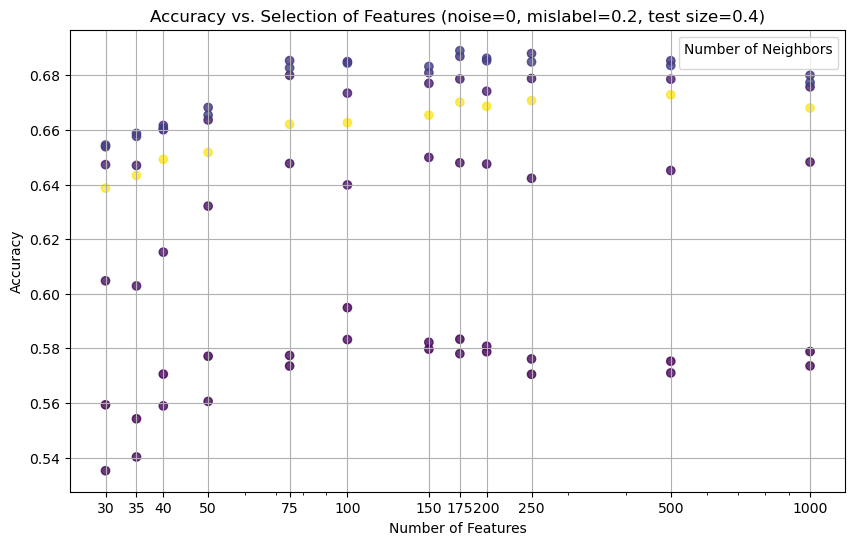

Best training k: 1
Best training score: 1.0
For k=1 and PCA components=50, CV Score: 0.578734814164495, Test Score: 0.9818153923904412
For k=2 and PCA components=100, CV Score: 0.5739148892781781, Test Score: 0.9978521406396651
For k=3 and PCA components=35, CV Score: 0.5574055371465434, Test Score: 0.9944171170026213
For k=5 and PCA components=100, CV Score: 0.5739148892781781, Test Score: 0.9957042812793301
For k=8 and PCA components=30, CV Score: 0.5569557972042369, Test Score: 0.9964803985271821
For k=10 and PCA components=100, CV Score: 0.5739148892781781, Test Score: 0.9936409997547689
For k=50 and PCA components=20, CV Score: 0.5619805478790753, Test Score: 0.9533460752005852
[{'k': 1, 'pca__n_components': 50, 'cv_score': 0.578734814164495, 'test_score': 0.9818153923904412}, {'k': 2, 'pca__n_components': 100, 'cv_score': 0.5739148892781781, 'test_score': 0.9978521406396651}, {'k': 3, 'pca__n_components': 35, 'cv_score': 0.5574055371465434, 'test_score': 0.9944171170026213}, {'k'

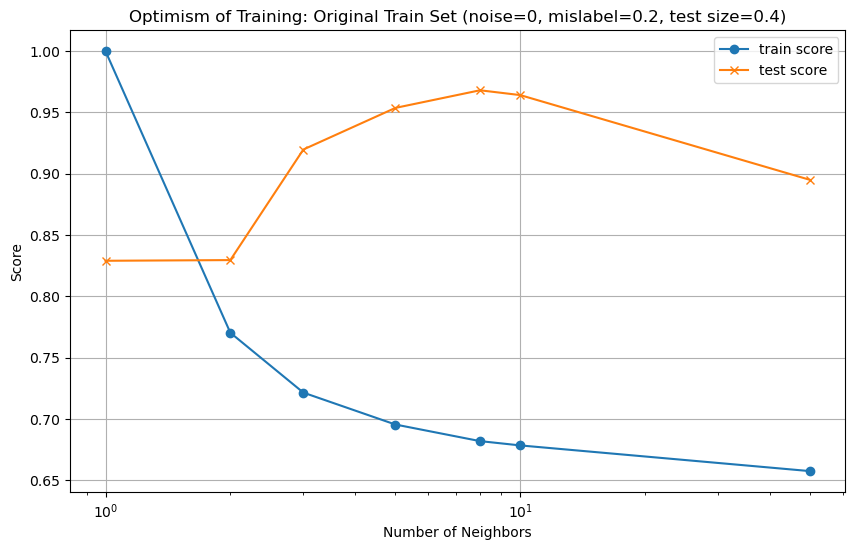

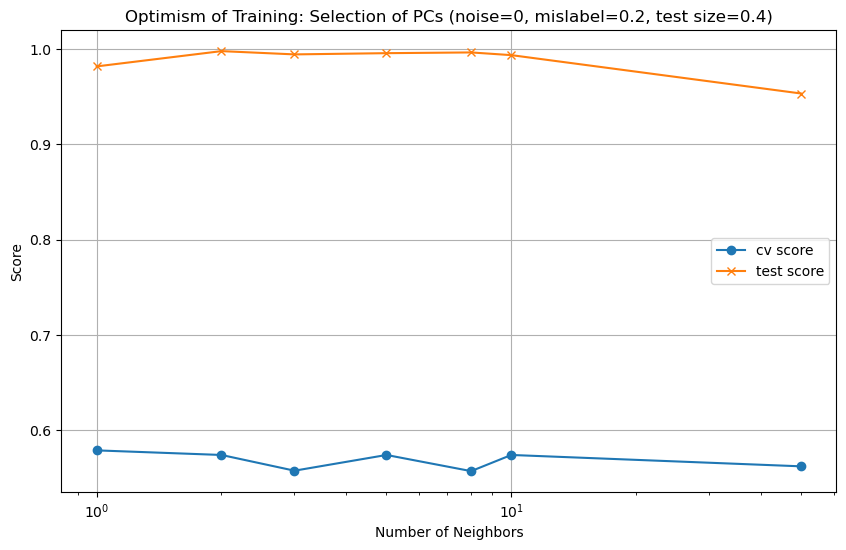

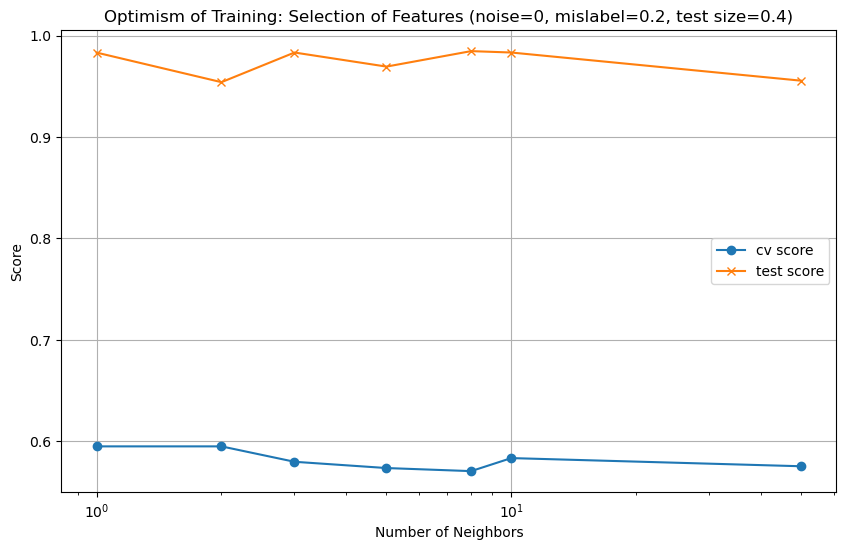

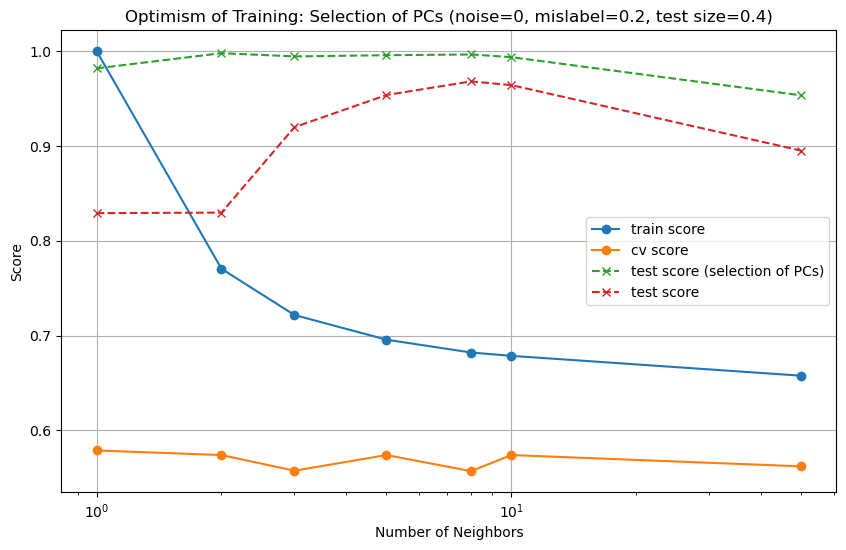

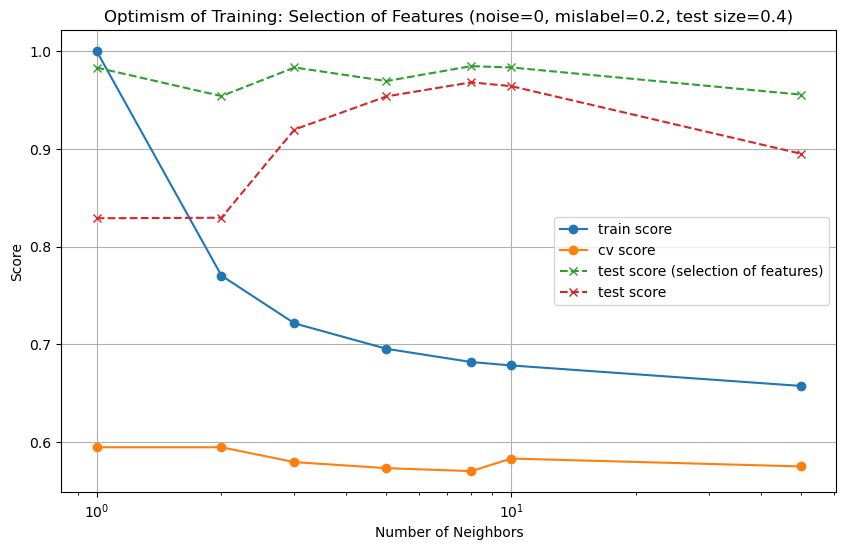



 ---------- TEST SIZE = 0.4 | MILSABEL PERCENTAGE = 0.4 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'pca__n_components': 35}
grid_search.best_score_:  0.4185643946679516


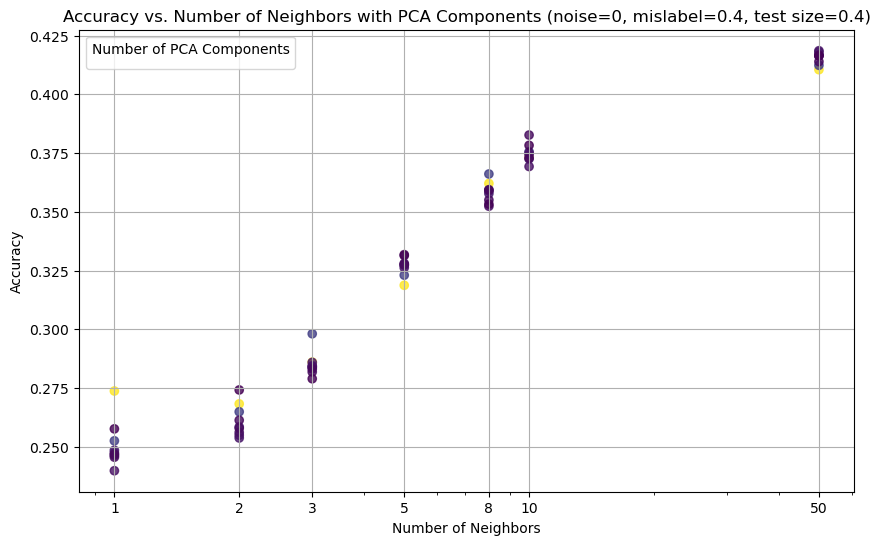

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


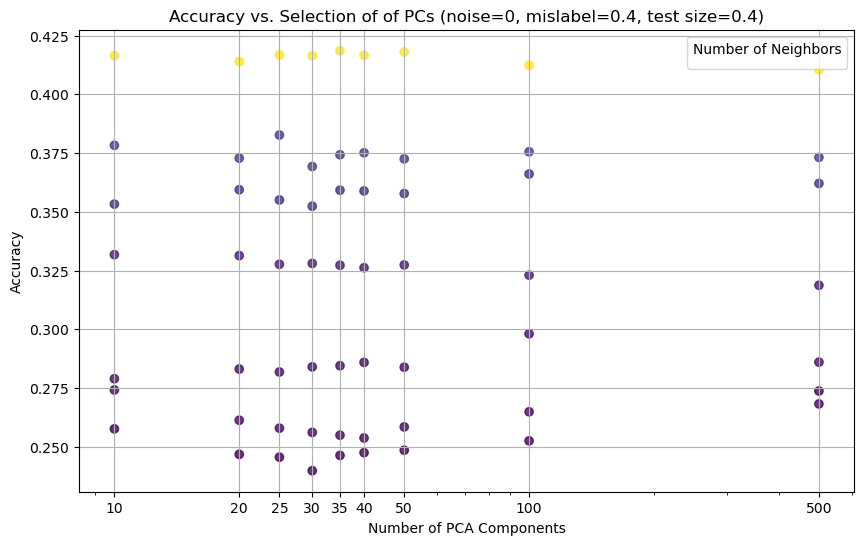

/tmp/ipykernel_4911/266210509.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'kbest__k': 100, 'kbest__score_func': <function f_classif at 0x7bea42544540>}
grid_search.best_score_:  0.4166543466616691


<Figure size 1000x600 with 0 Axes>

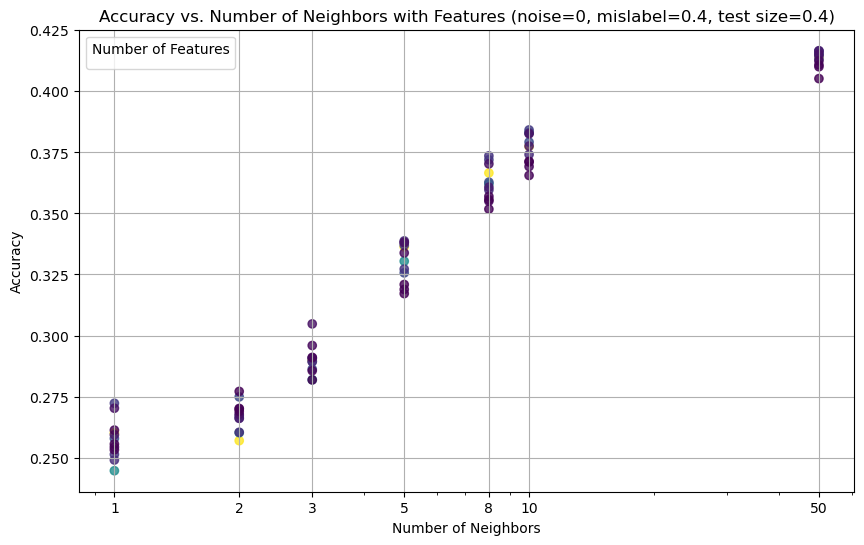

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


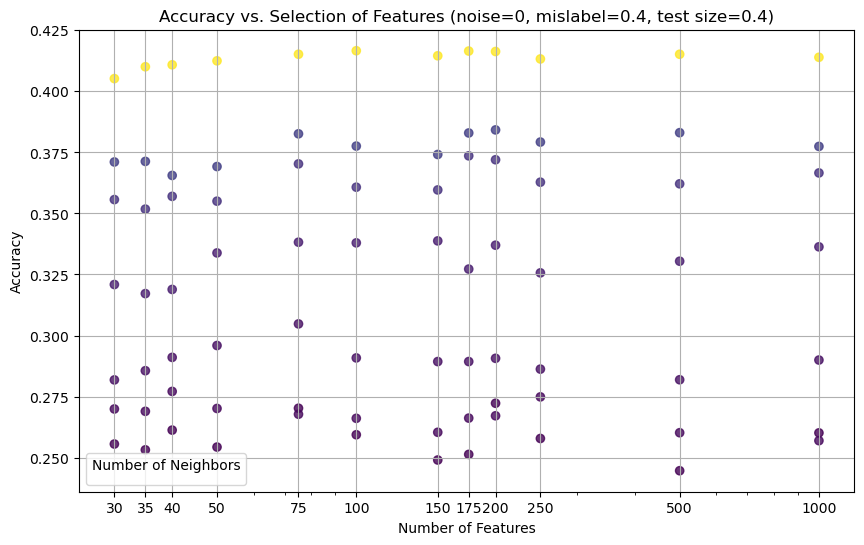

Best training k: 1
Best training score: 1.0
For k=1 and PCA components=500, CV Score: 0.27375394814592086, Test Score: 0.9926442050270537
For k=2 and PCA components=10, CV Score: 0.25763646826861136, Test Score: 0.9284922740309945
For k=3 and PCA components=100, CV Score: 0.2525490644574888, Test Score: 0.9950184102230887
For k=5 and PCA components=10, CV Score: 0.25763646826861136, Test Score: 0.9715363511659807
For k=8 and PCA components=100, CV Score: 0.2525490644574888, Test Score: 0.9943268708110105
For k=10 and PCA components=25, CV Score: 0.24558844352128134, Test Score: 0.9944114486467844
For k=50 and PCA components=35, CV Score: 0.24633288674237538, Test Score: 0.9554939345609202
[{'k': 1, 'pca__n_components': 500, 'cv_score': 0.27375394814592086, 'test_score': 0.9926442050270537}, {'k': 2, 'pca__n_components': 10, 'cv_score': 0.25763646826861136, 'test_score': 0.9284922740309945}, {'k': 3, 'pca__n_components': 100, 'cv_score': 0.2525490644574888, 'test_score': 0.9950184102230

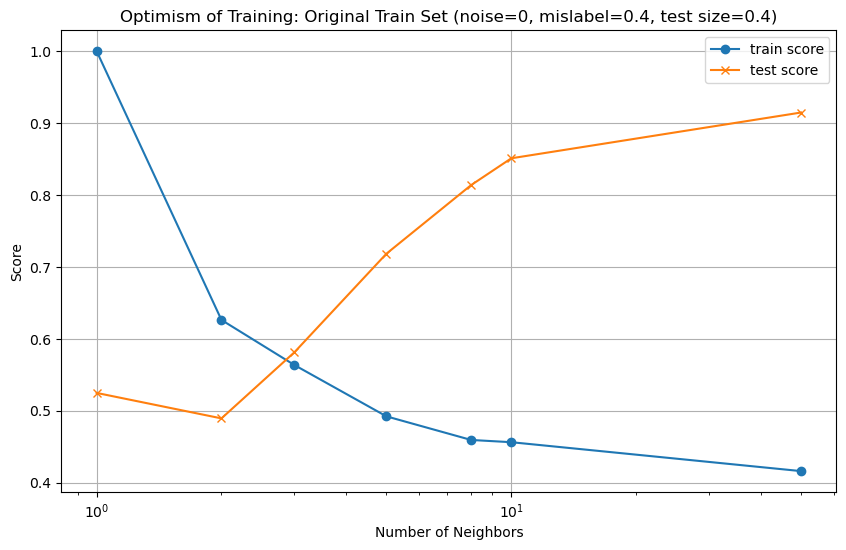

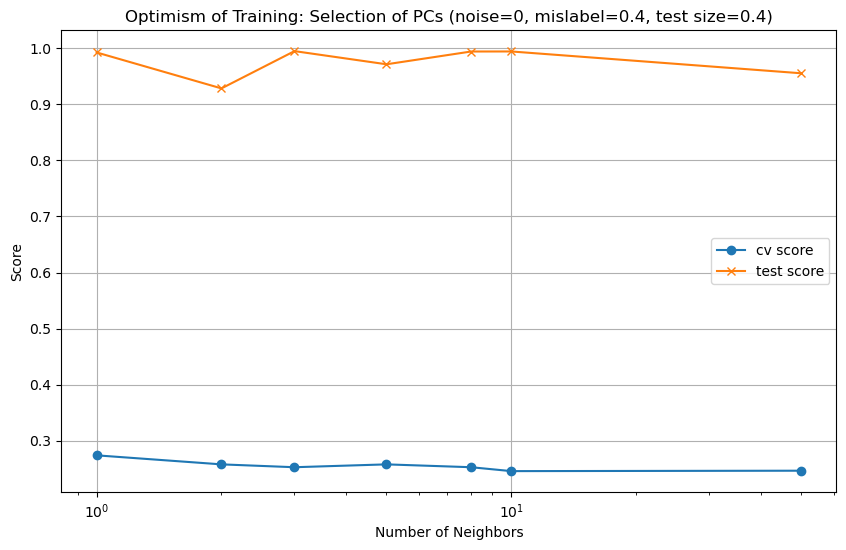

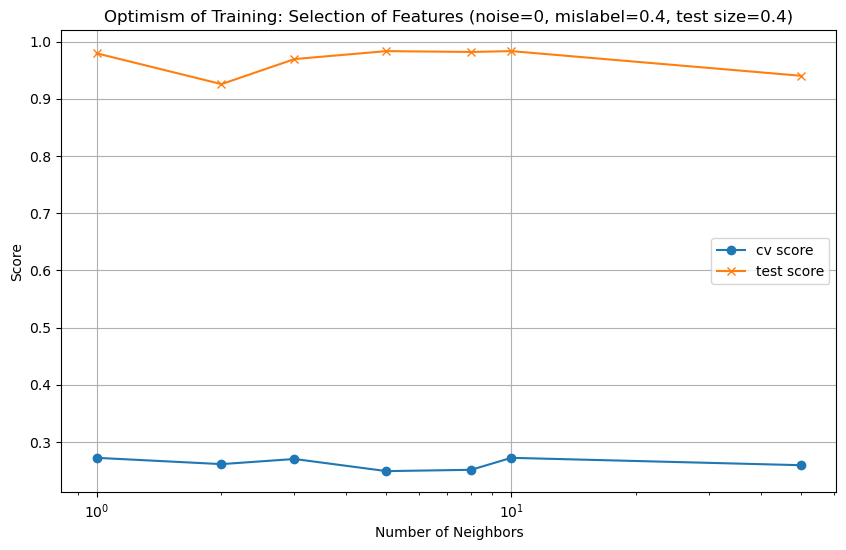

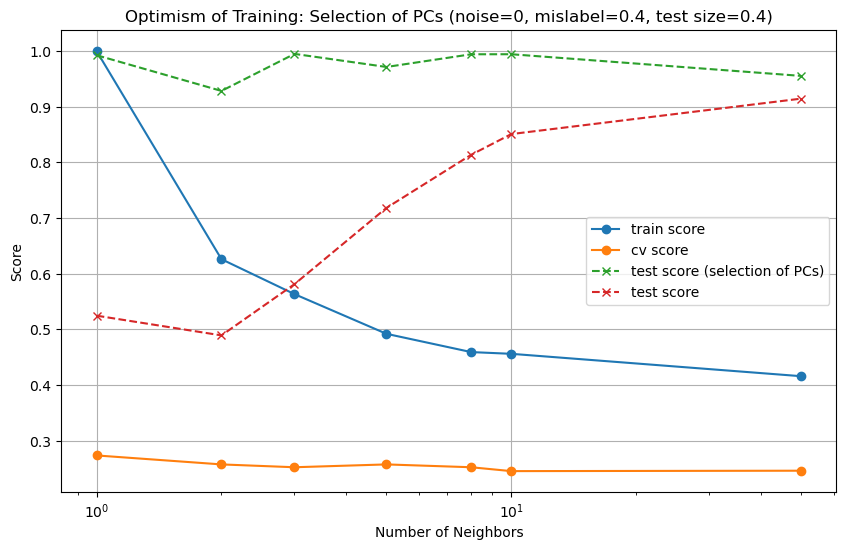

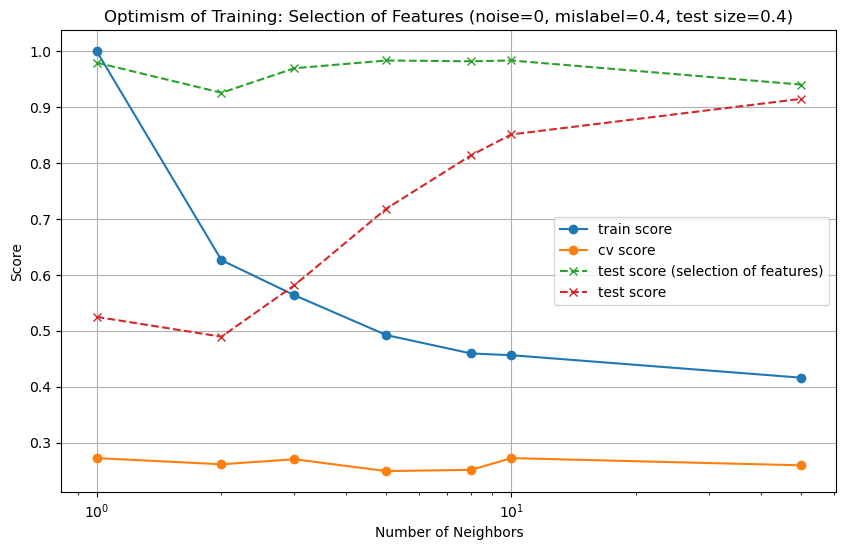



 ---------- TEST SIZE = 0.4 | MILSABEL PERCENTAGE = 0.6 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 10, 'pca__n_components': 25}
grid_search.best_score_:  0.2155152982173334


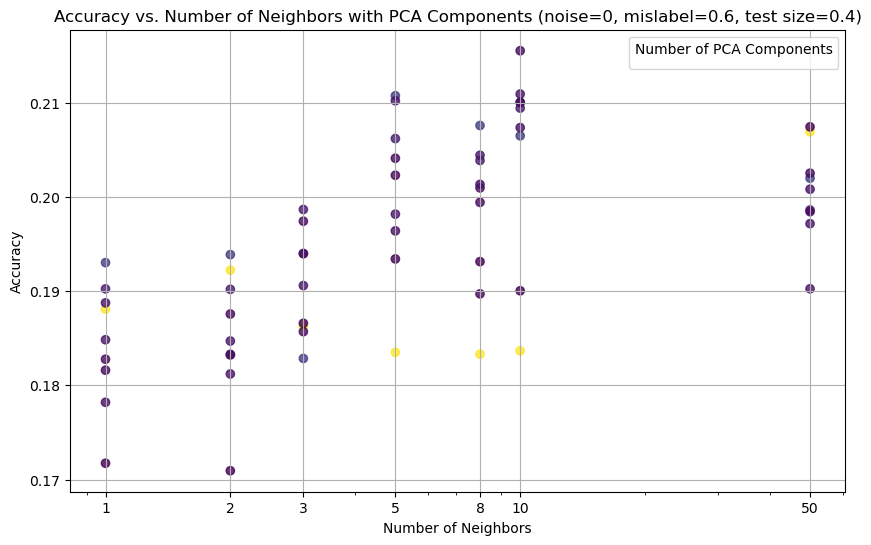

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


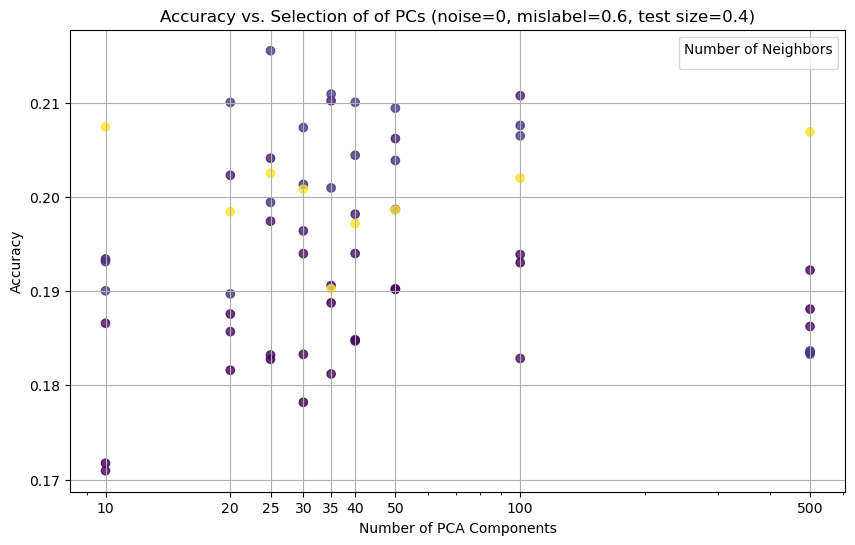

/tmp/ipykernel_4911/266210509.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', len(unique_features))  # Color map
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 50, 'kbest__k': 1000, 'kbest__score_func': <function f_classif at 0x7bea42544540>}
grid_search.best_score_:  0.21100813283140787


<Figure size 1000x600 with 0 Axes>

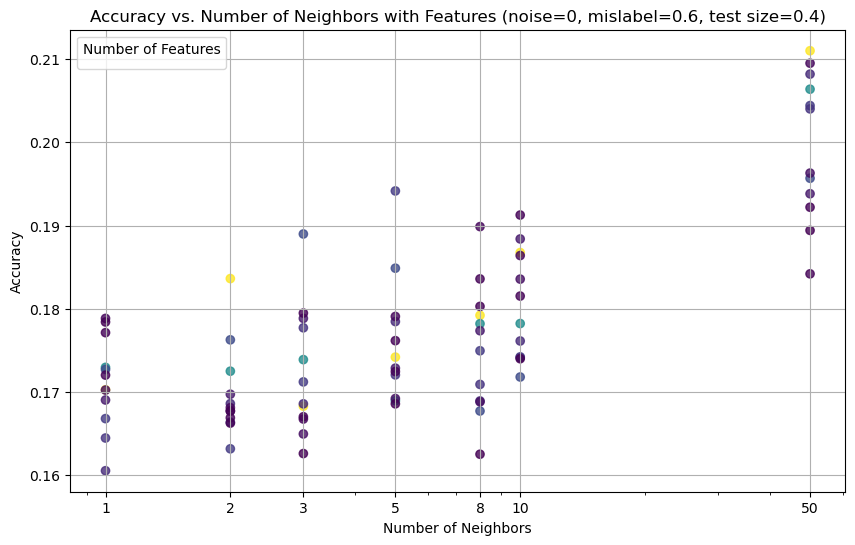

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


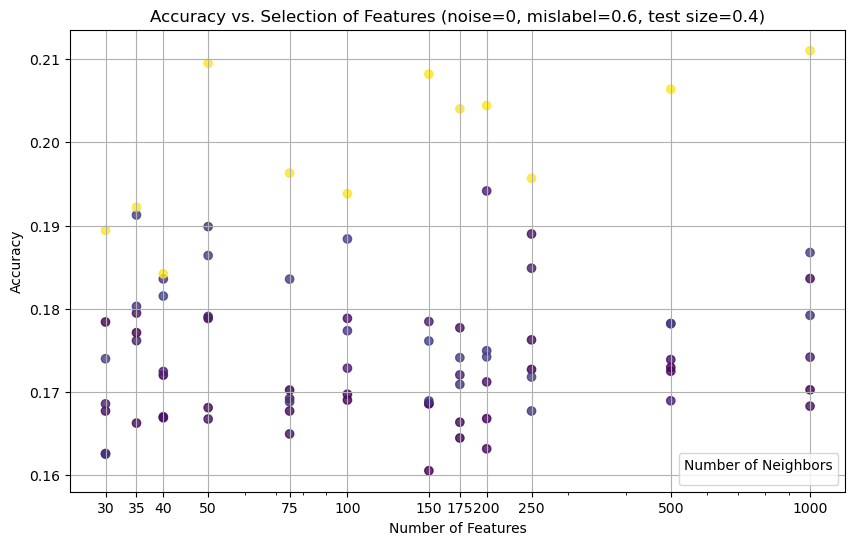

Best training k: 1
Best training score: 1.0
For k=1 and PCA components=100, CV Score: 0.19302267059932798, Test Score: 0.9925596271912797
For k=2 and PCA components=100, CV Score: 0.19302267059932798, Test Score: 0.9971662695834236
For k=3 and PCA components=50, CV Score: 0.19023787563518266, Test Score: 0.9971662695834236
For k=5 and PCA components=100, CV Score: 0.19302267059932798, Test Score: 0.9957042812793301
For k=8 and PCA components=100, CV Score: 0.19302267059932798, Test Score: 0.9943268708110105
For k=10 and PCA components=25, CV Score: 0.18277288991953436, Test Score: 0.9944114486467844
For k=50 and PCA components=10, CV Score: 0.1717322837642446, Test Score: 0.9401430573679378
[{'k': 1, 'pca__n_components': 100, 'cv_score': 0.19302267059932798, 'test_score': 0.9925596271912797}, {'k': 2, 'pca__n_components': 100, 'cv_score': 0.19302267059932798, 'test_score': 0.9971662695834236}, {'k': 3, 'pca__n_components': 50, 'cv_score': 0.19023787563518266, 'test_score': 0.9971662695

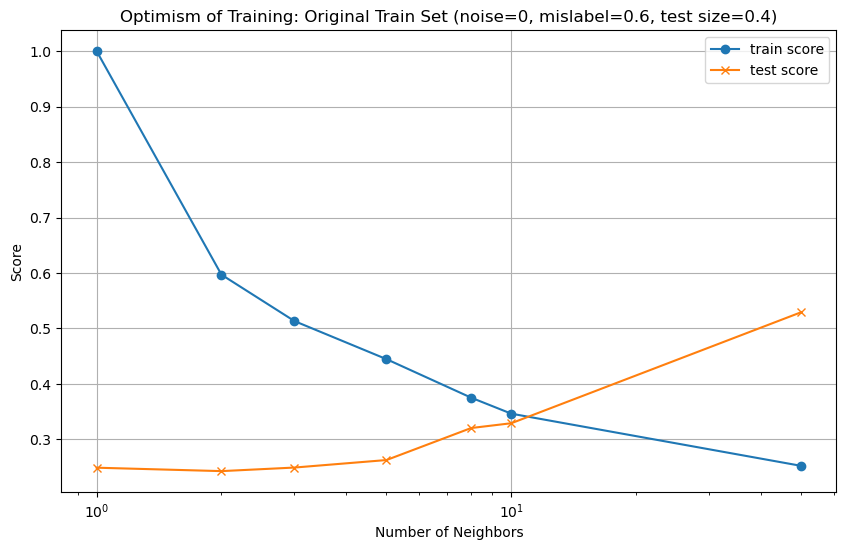

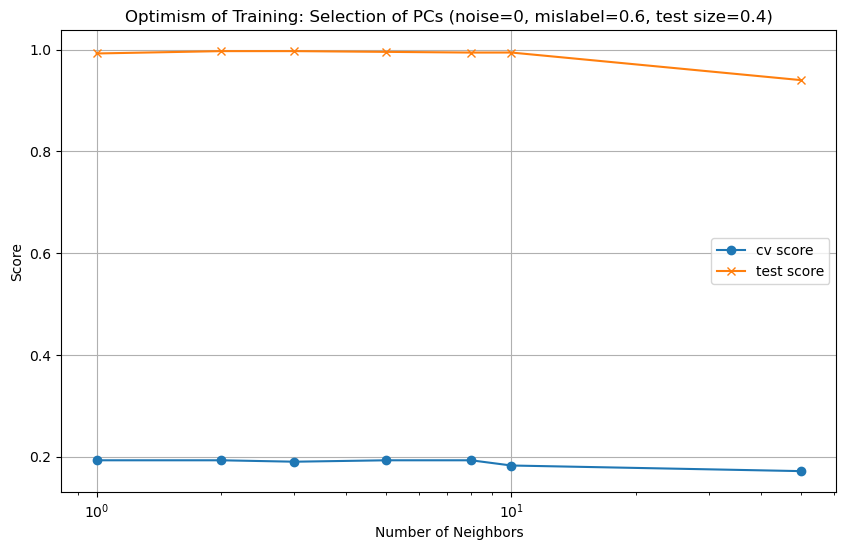

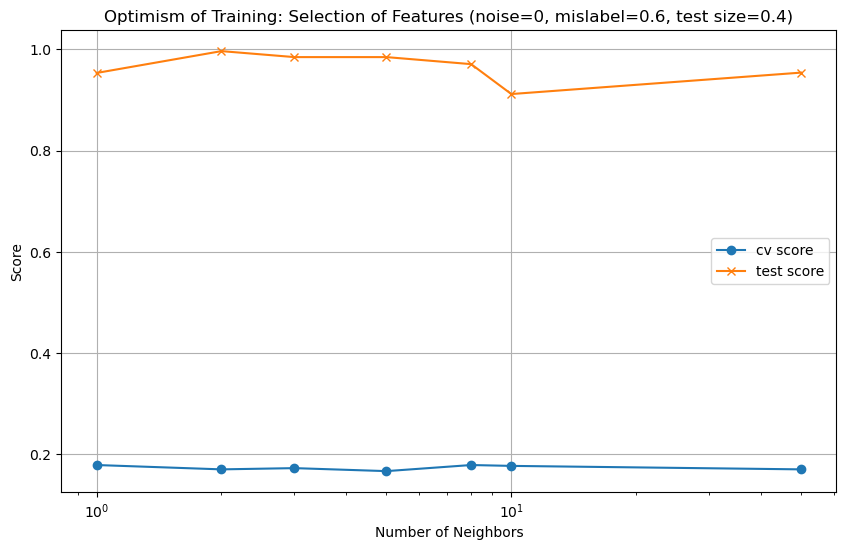

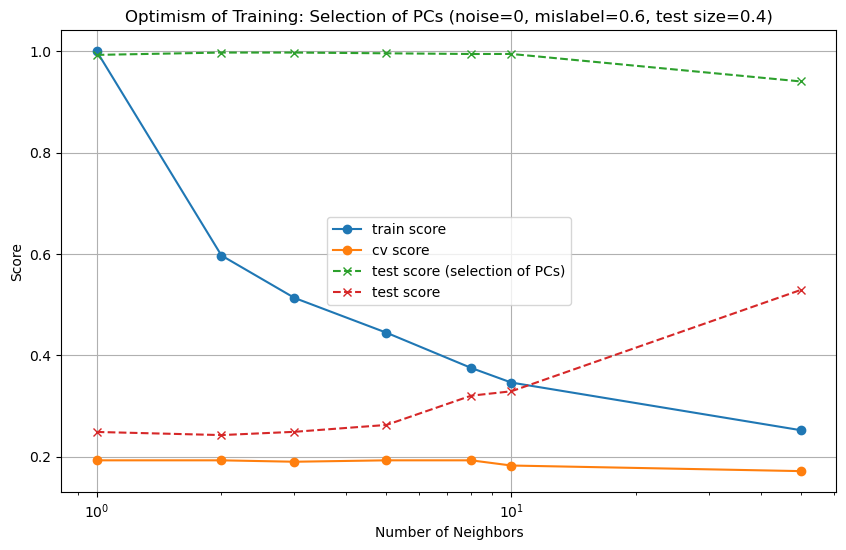

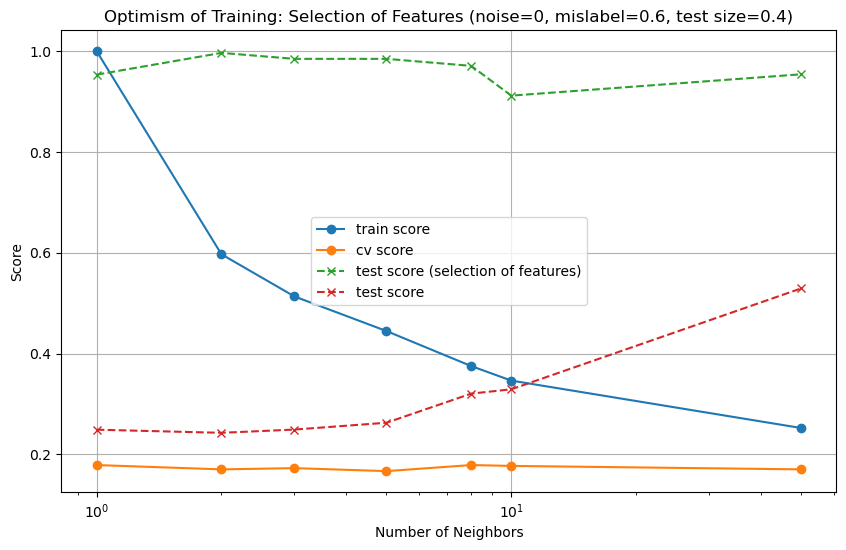



 X_train shape = (866, 2000), Y_train shape = (866, 1)


 ---------- TEST SIZE = 0.7 | MILSABEL PERCENTAGE = 0 ---------- 




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


grid_search.best_params_:  {'estimator__n_neighbors': 1, 'pca__n_components': 25}
grid_search.best_score_:  0.9591122004357299


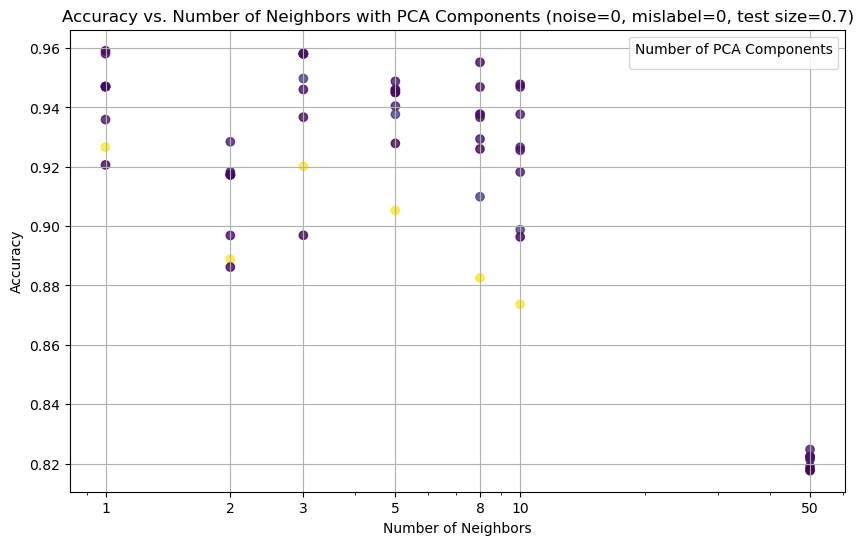

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


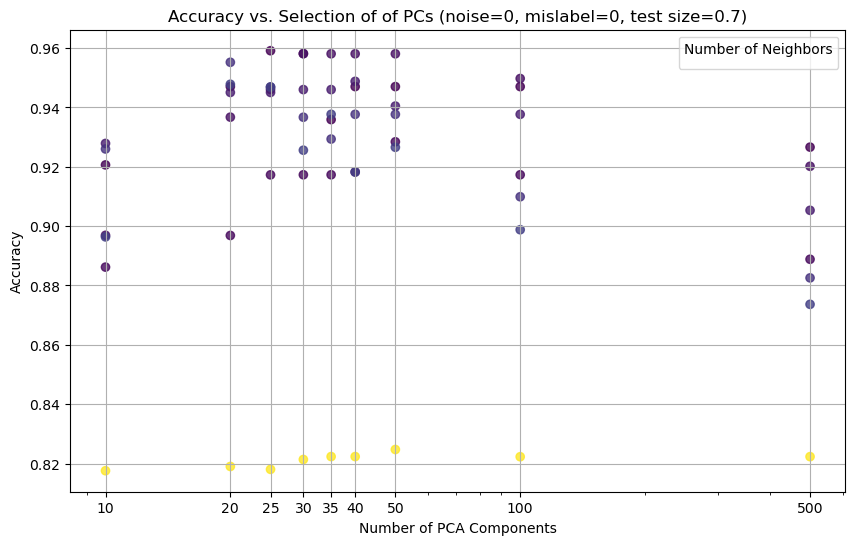

In [148]:
main()